Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gen0401. Use `wandb login --relogin` to force relogin


Start loading dataset


Epochs:   0%|                                                                | 0/50 [00:00<?, ?it/s]

creating a data of BrandSilence00024


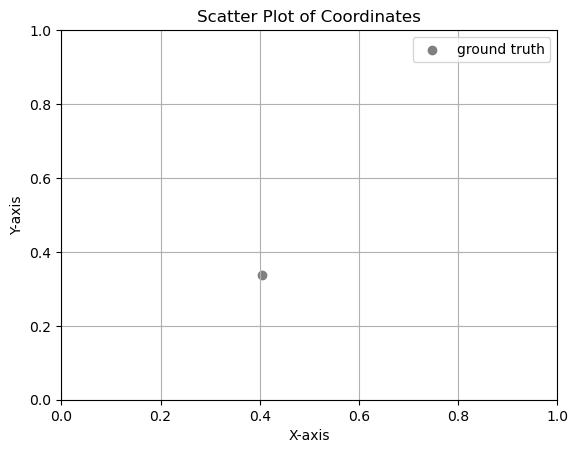

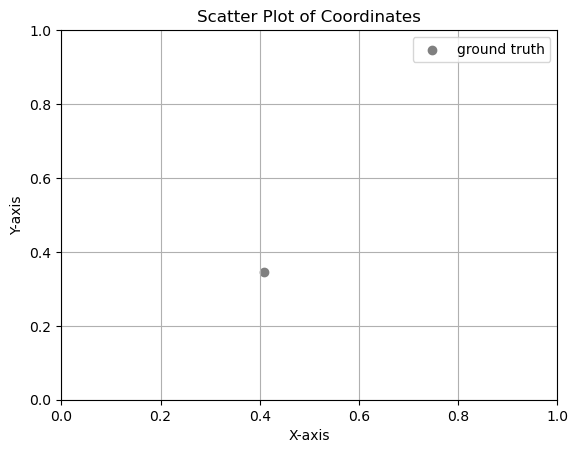

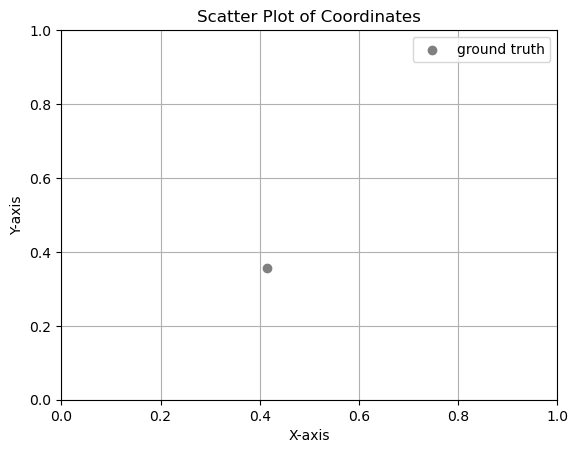

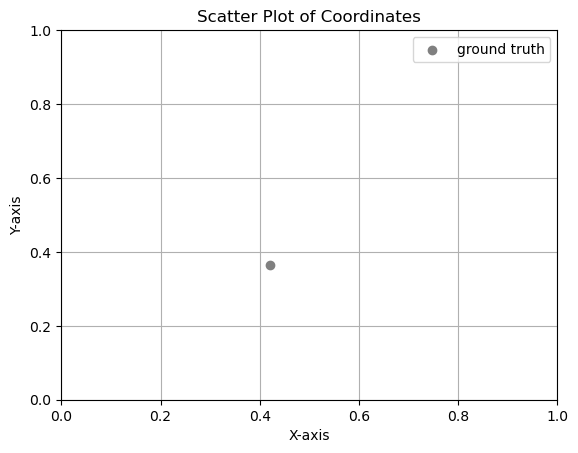

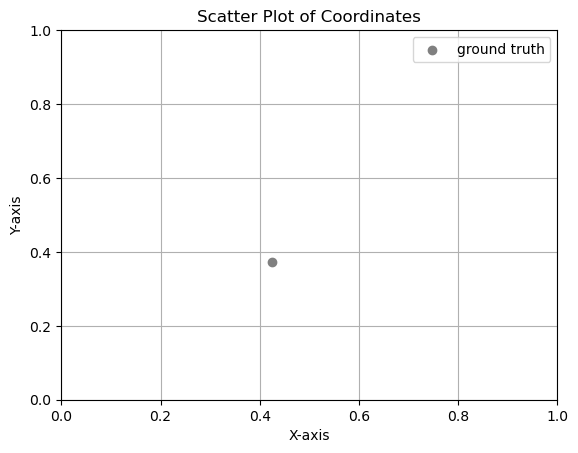

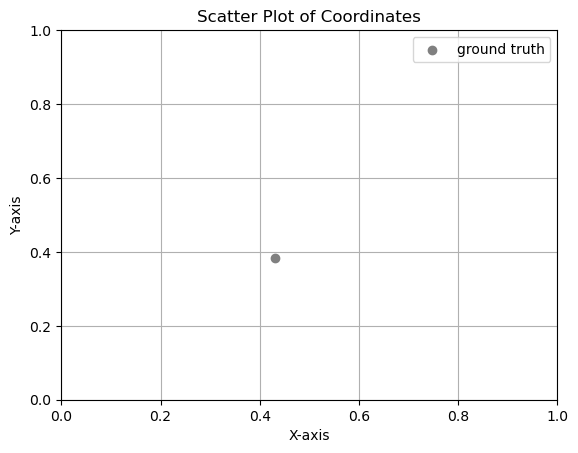

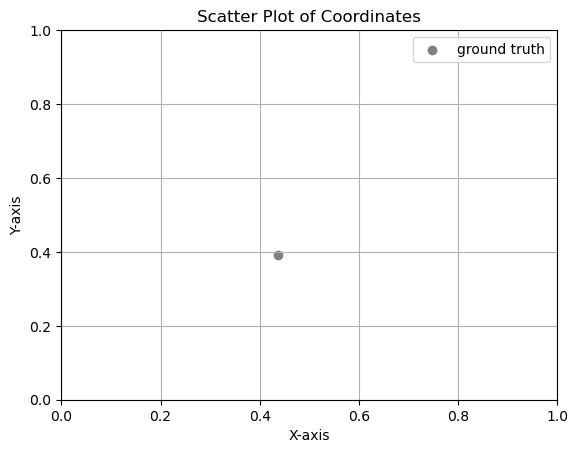

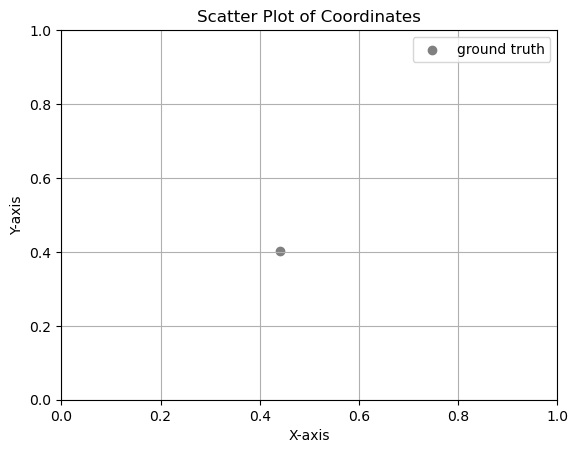

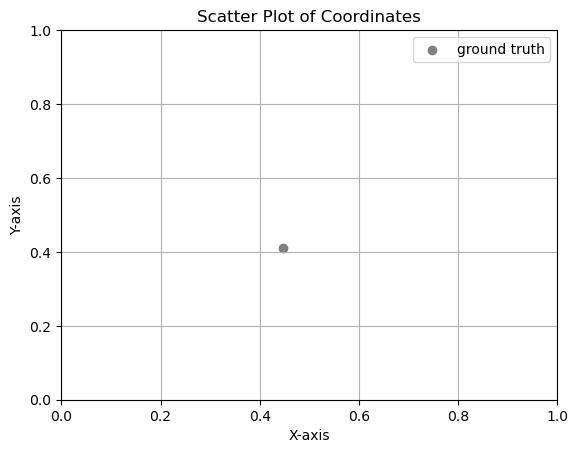

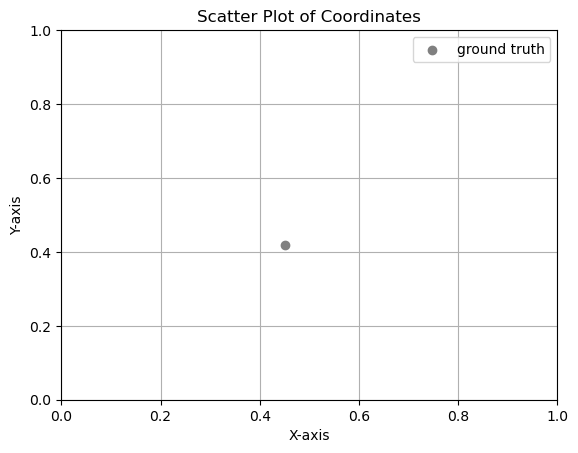

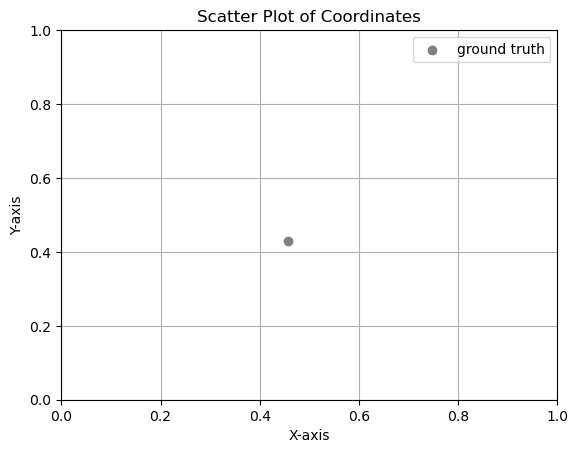

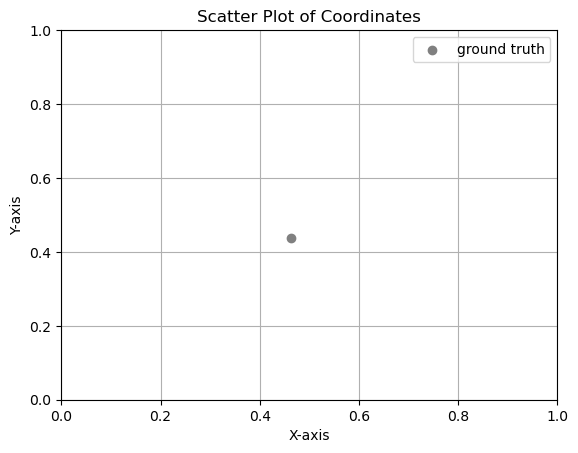

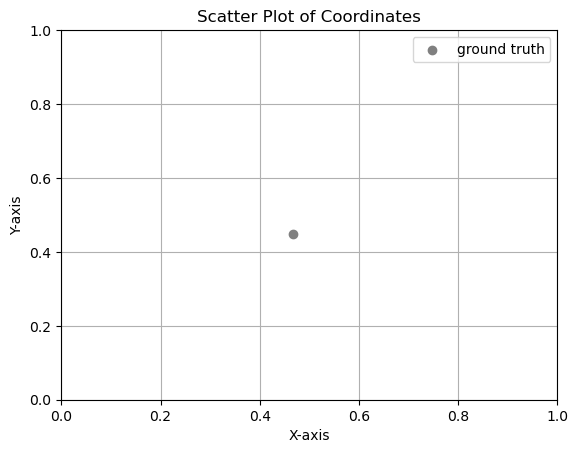

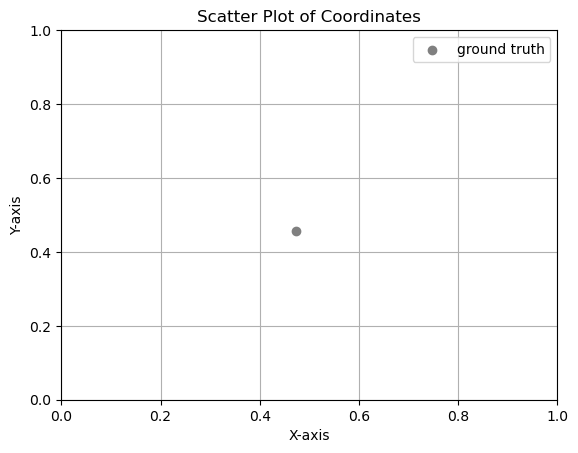

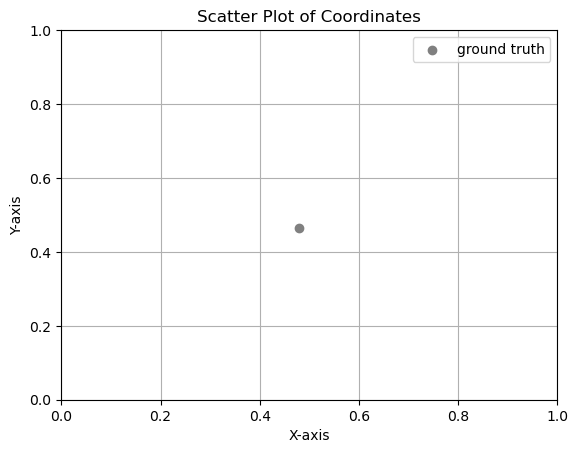

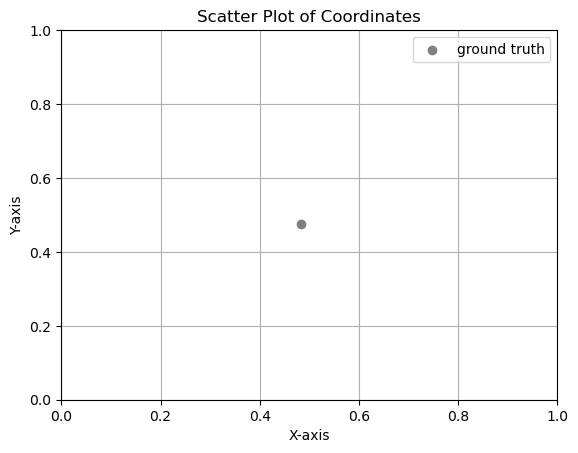

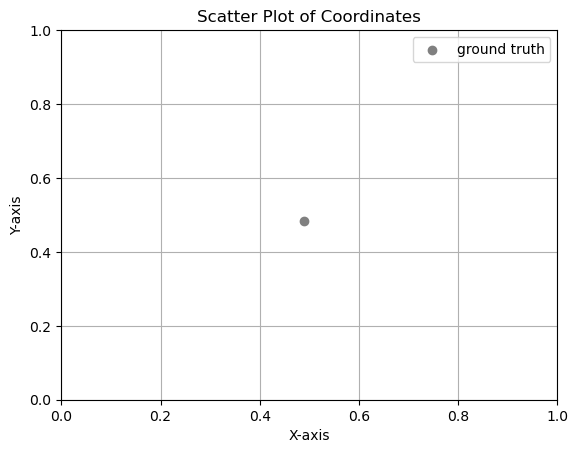

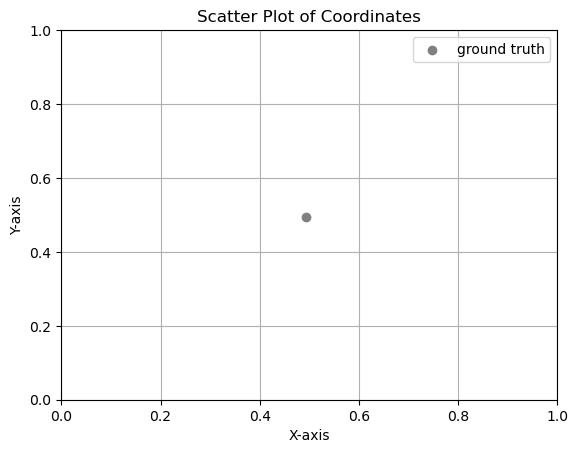

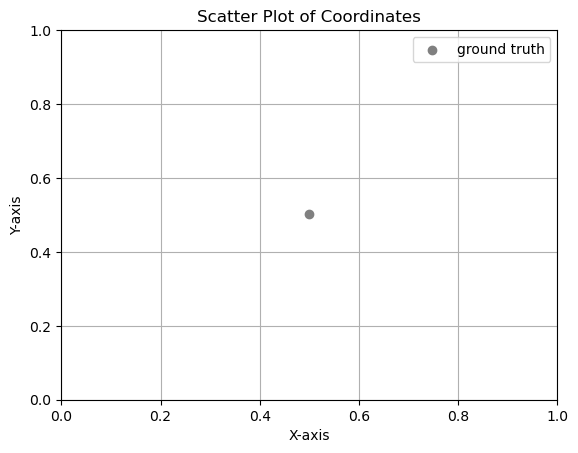

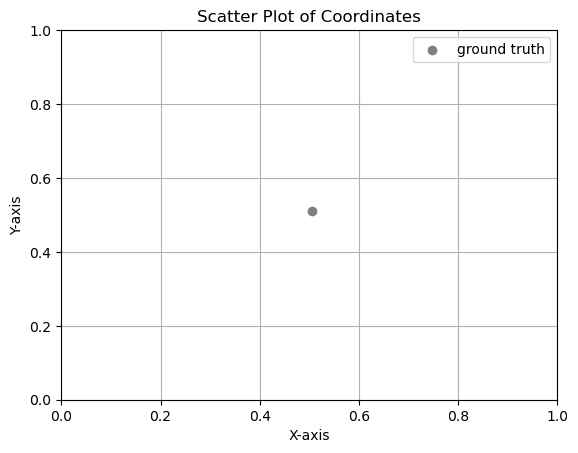

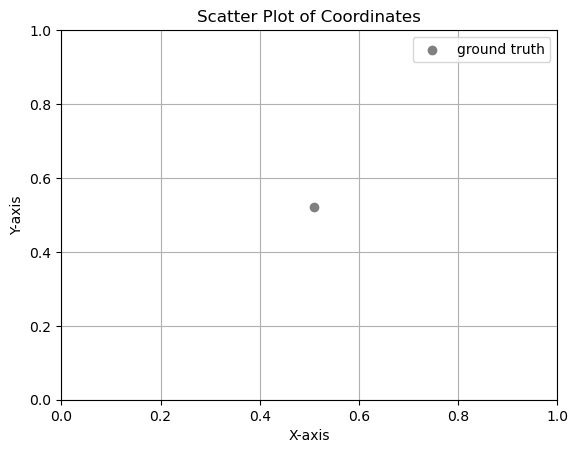

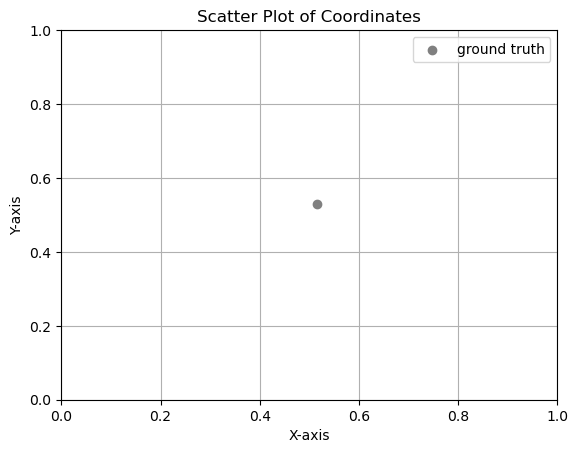

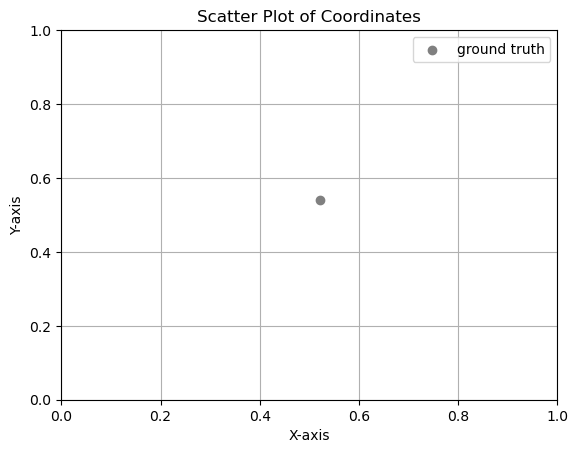

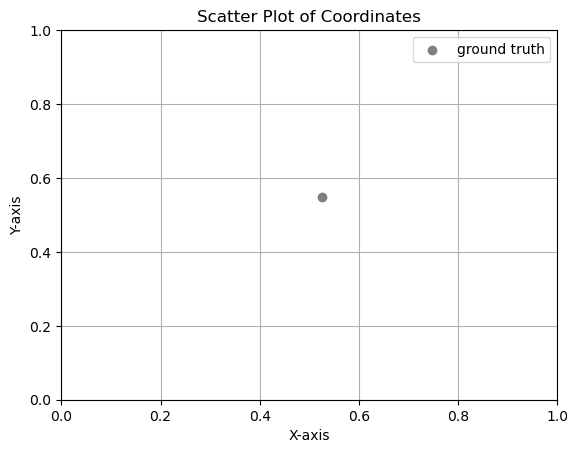

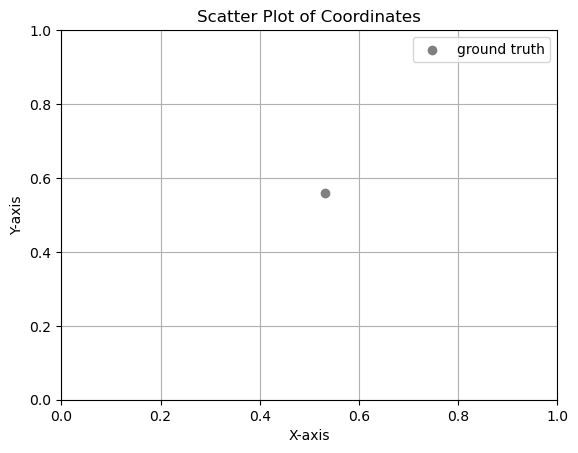

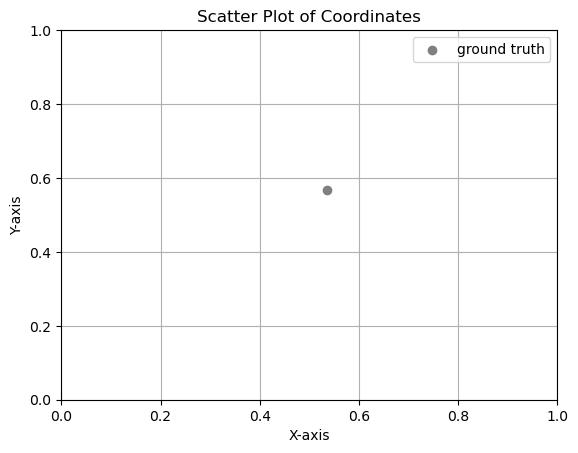

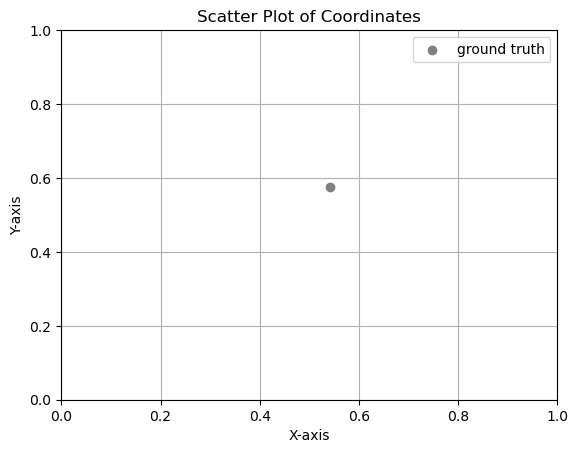

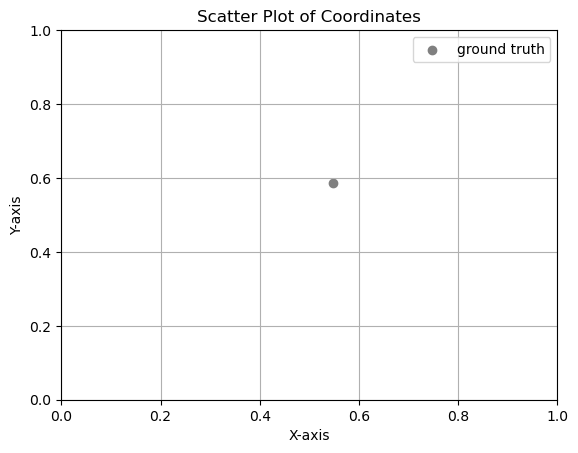

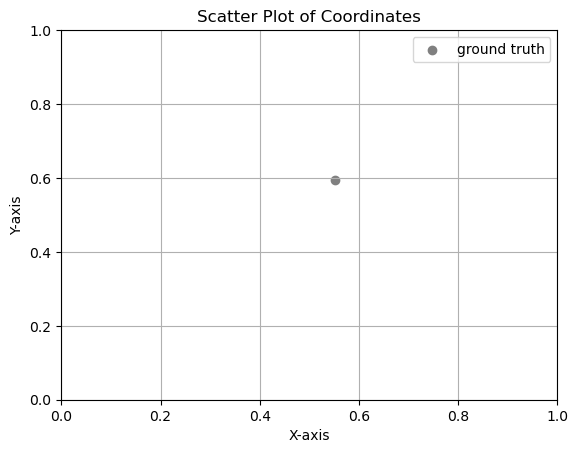

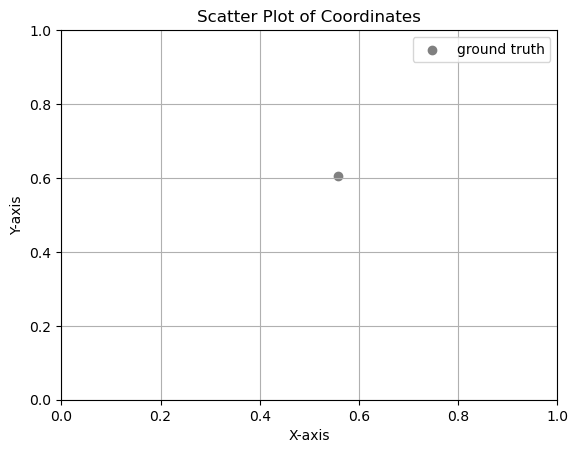

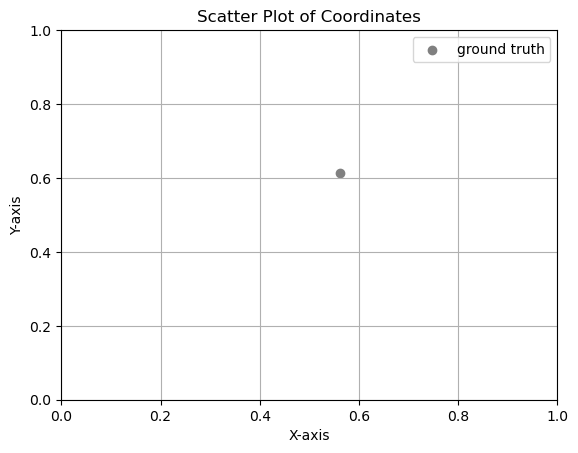

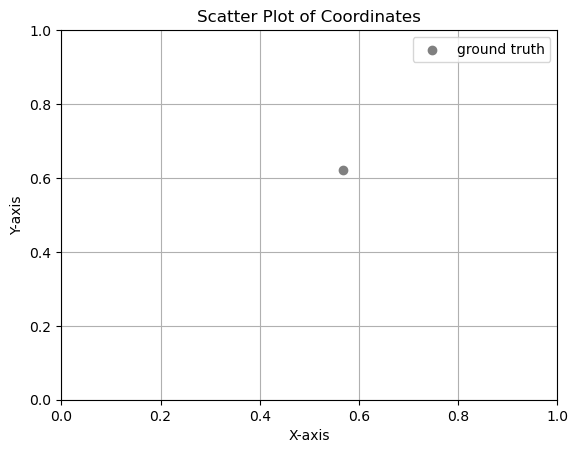

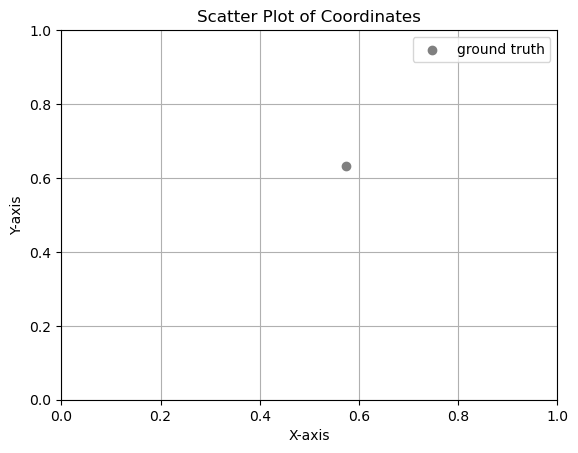

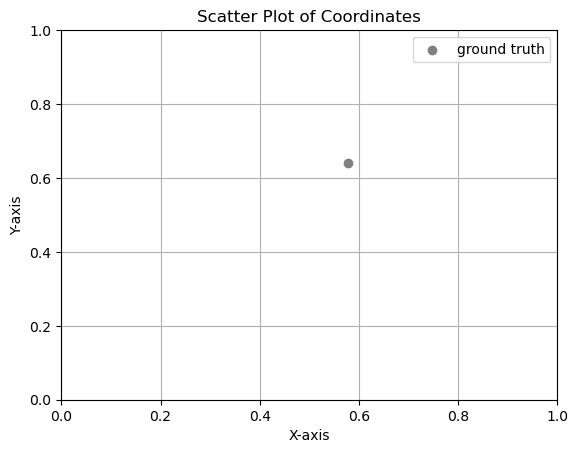

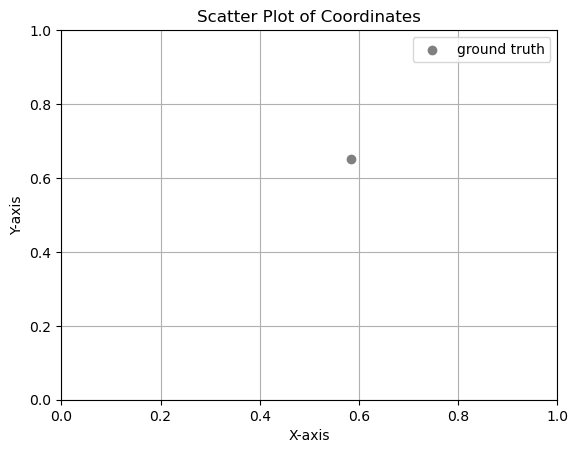

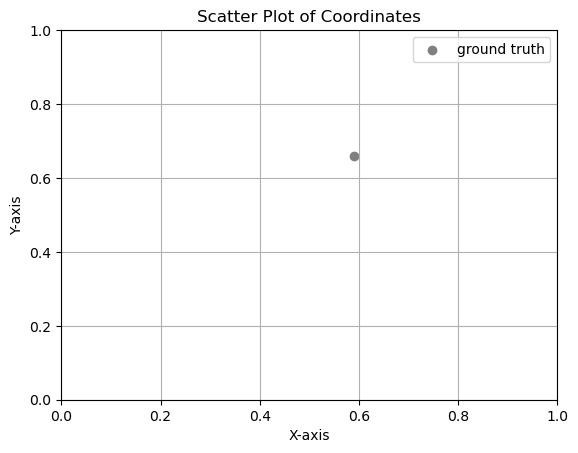

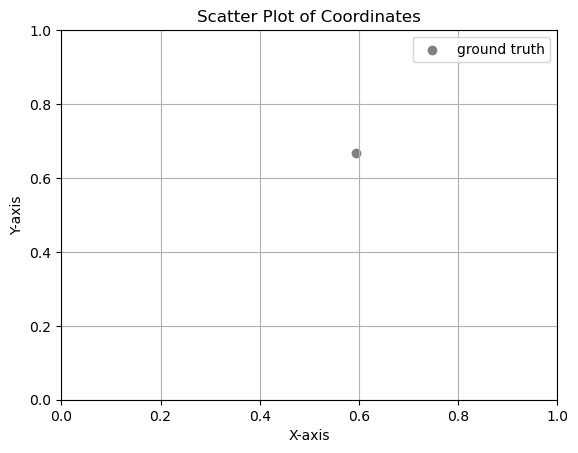

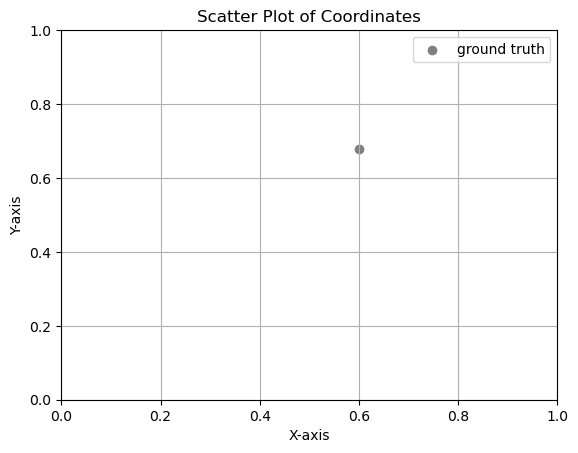

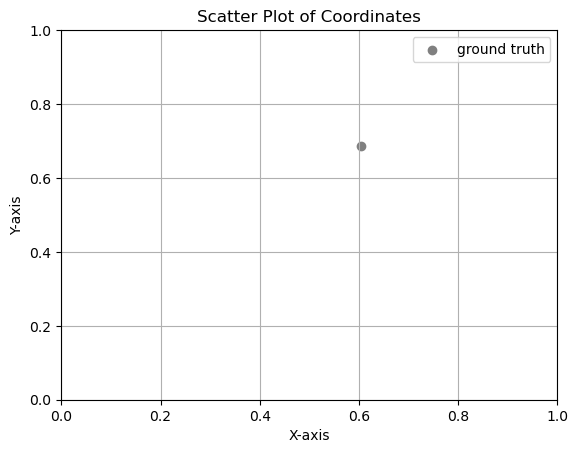

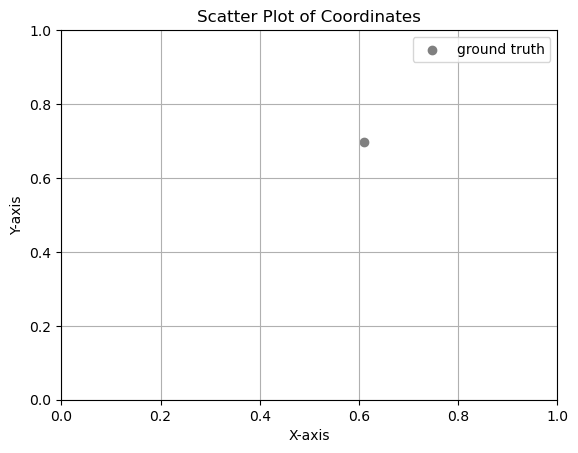

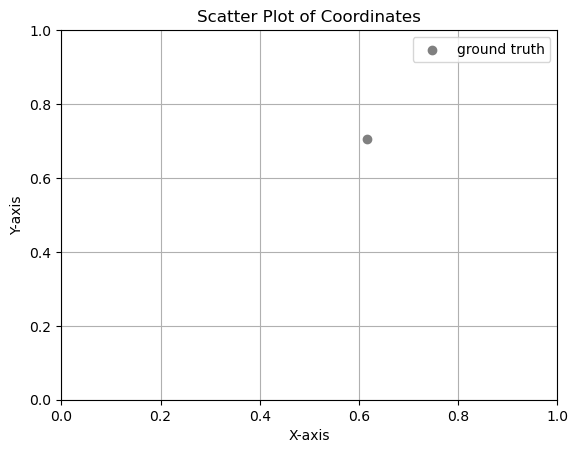

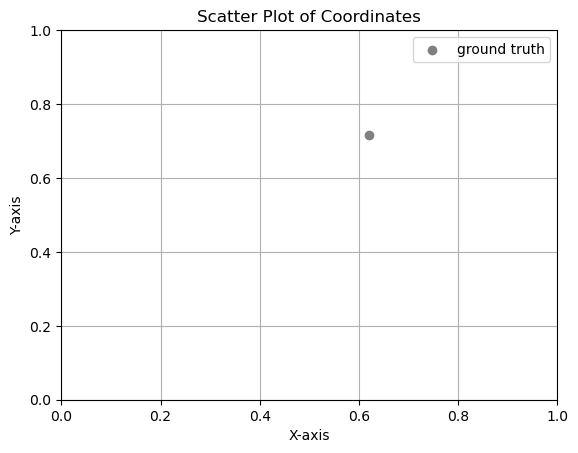

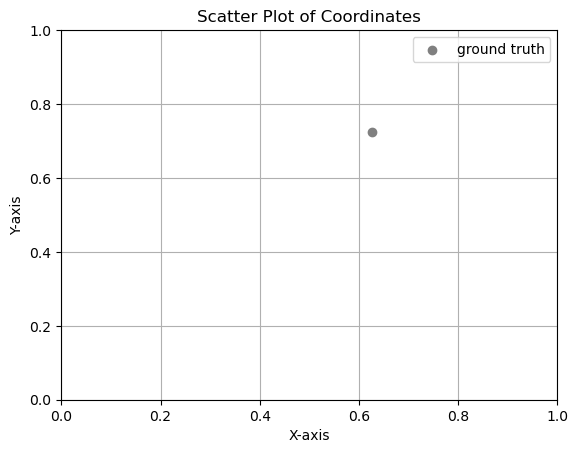

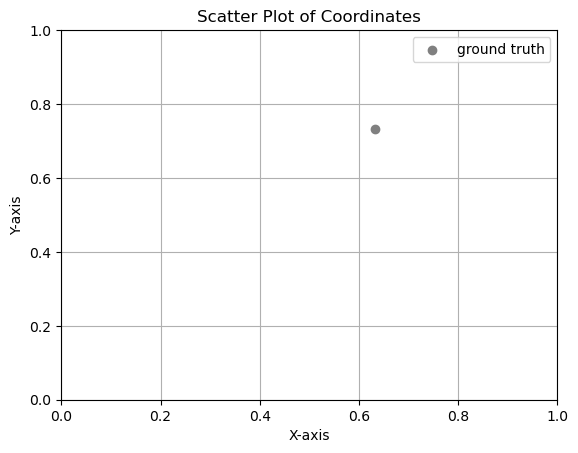

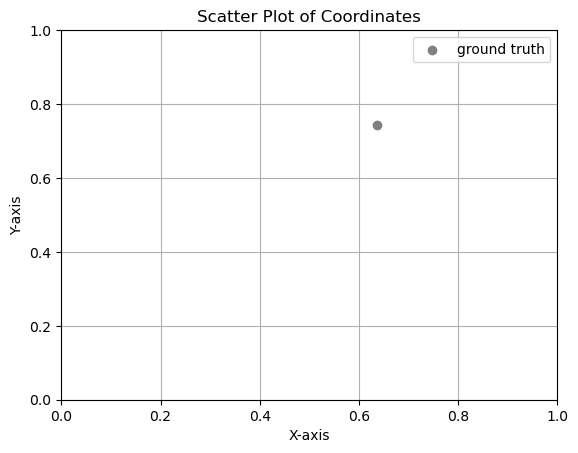

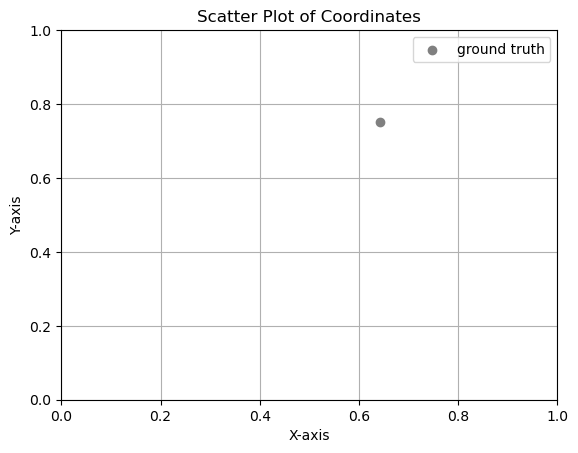

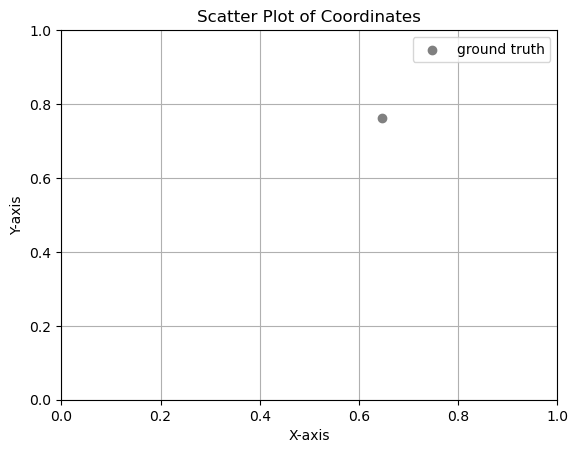

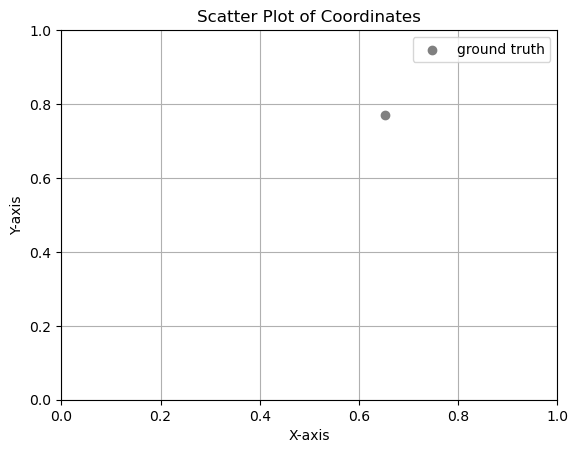

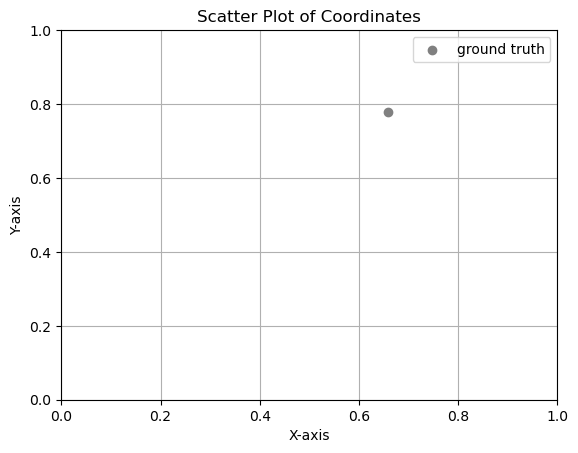

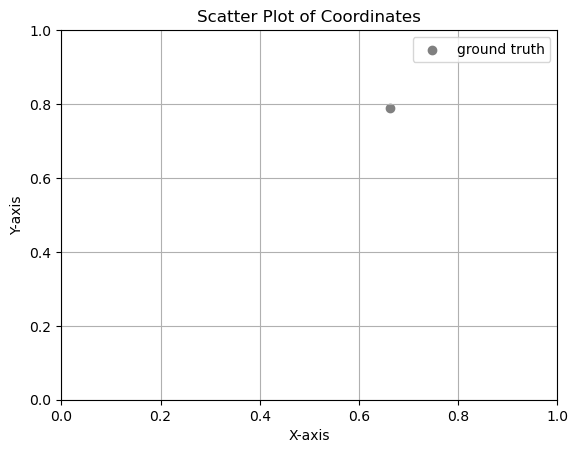

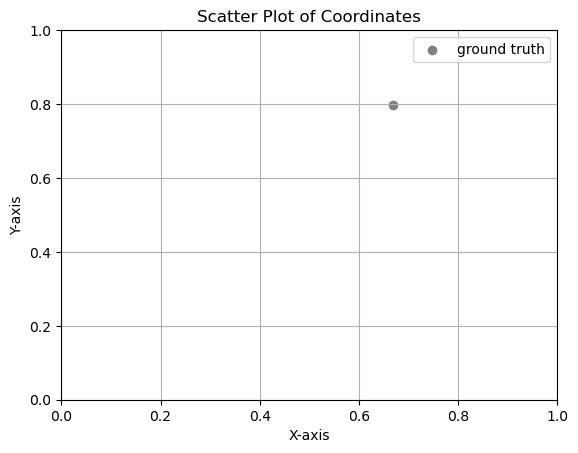

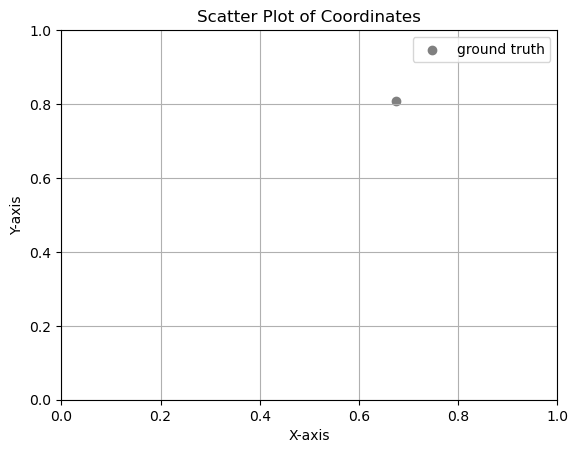

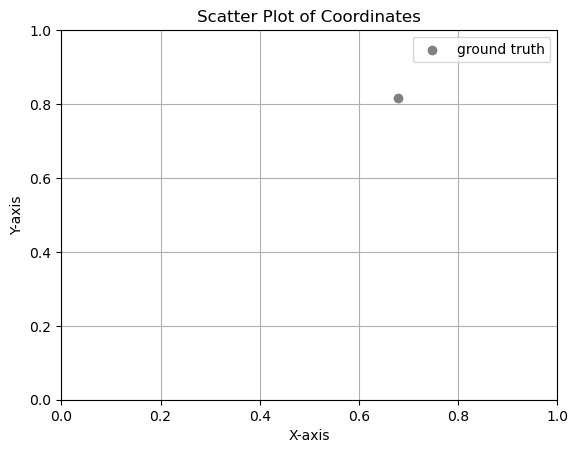

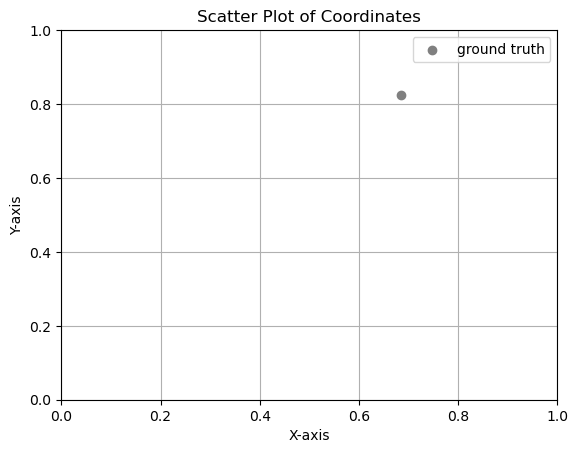

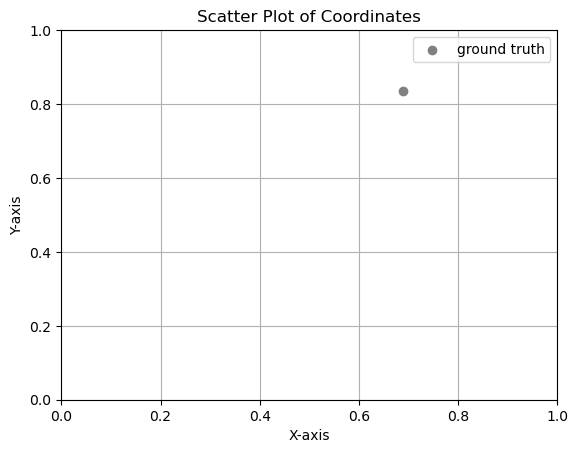

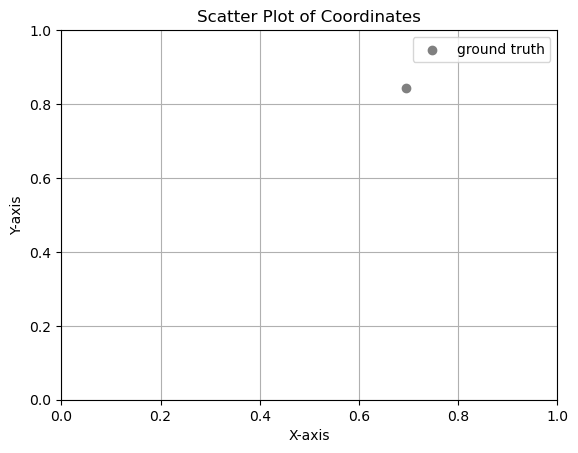

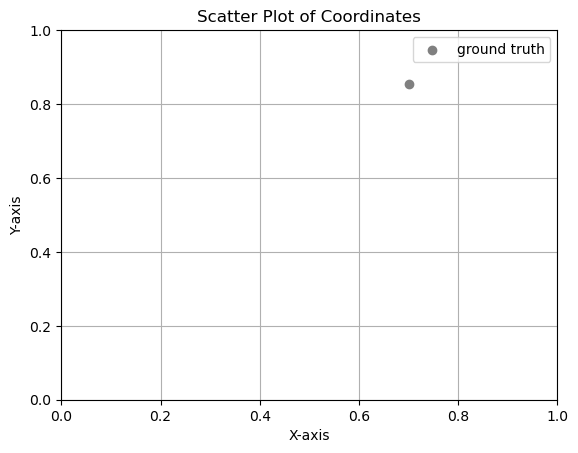

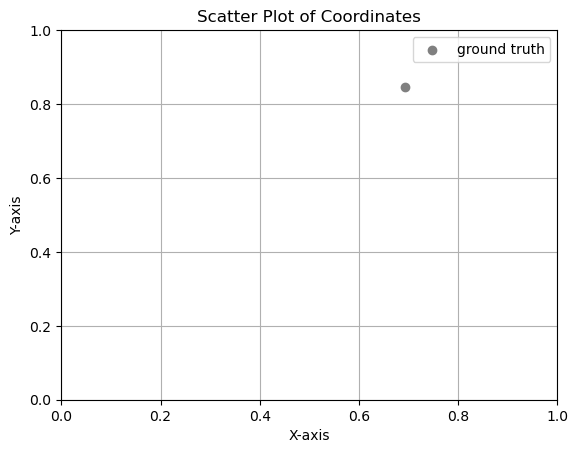

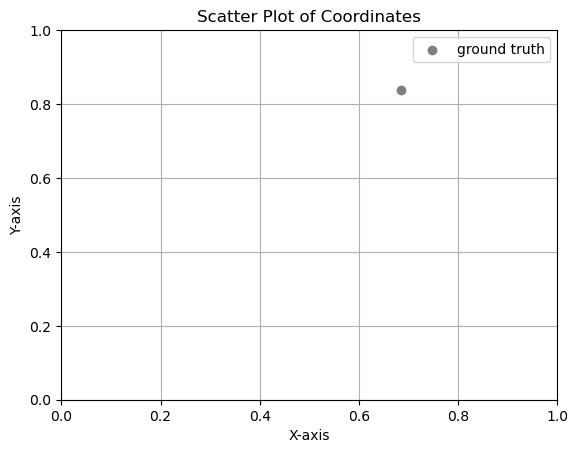

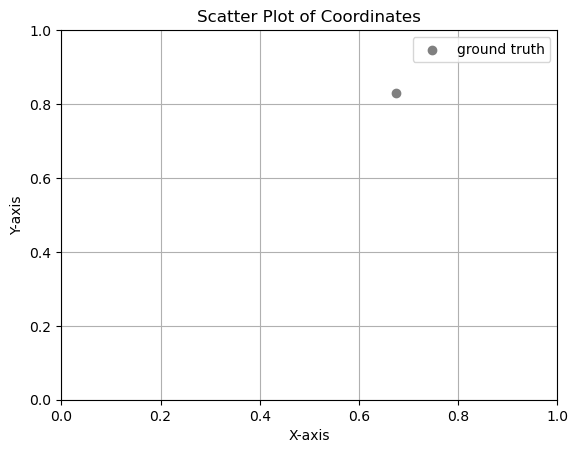

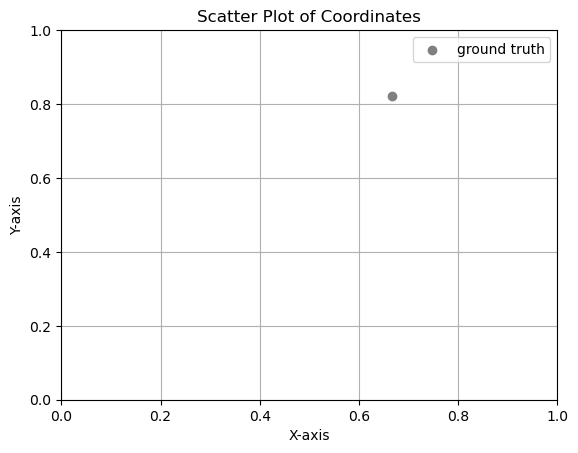

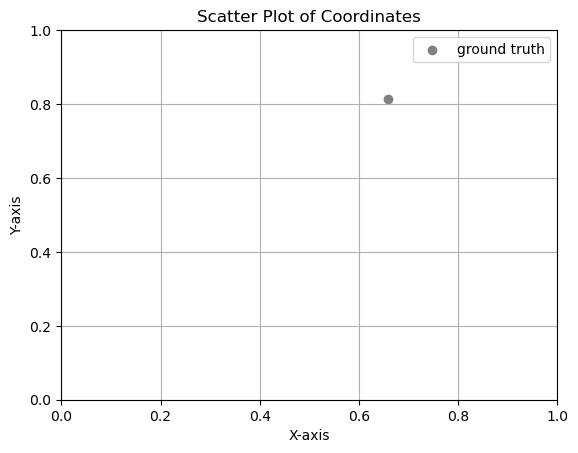

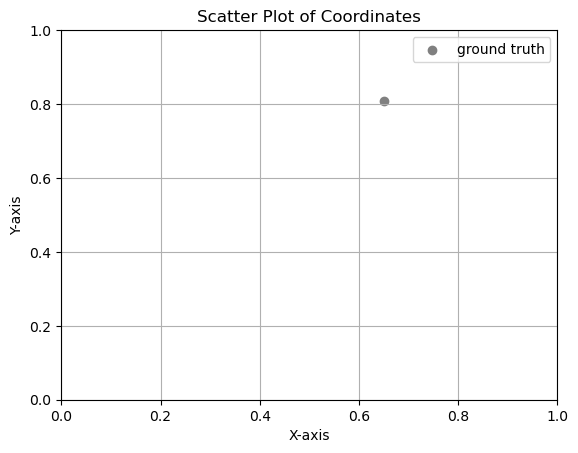

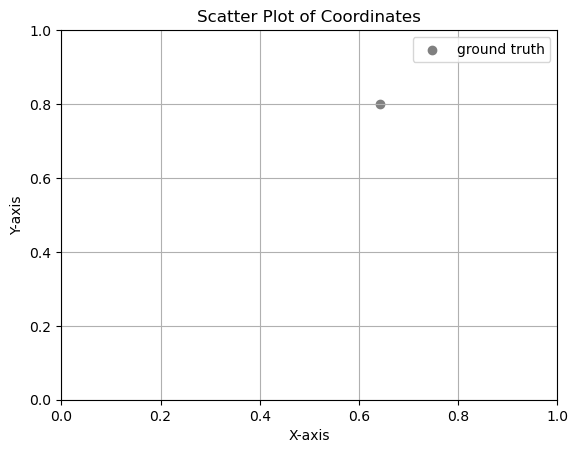

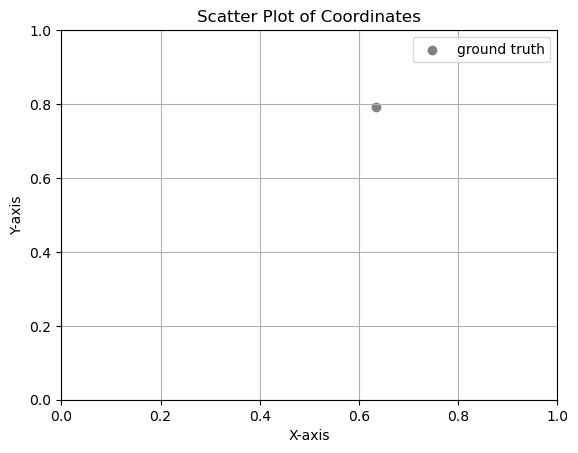

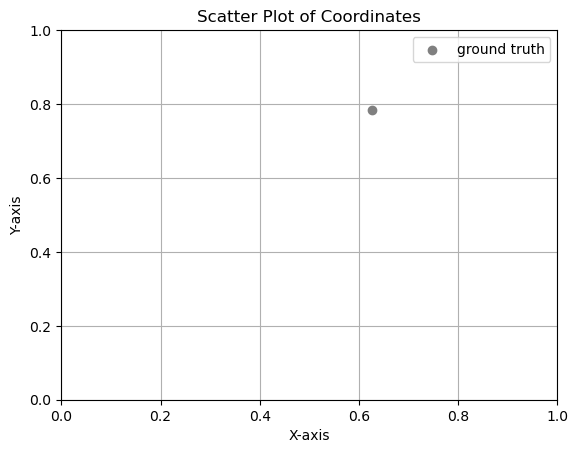

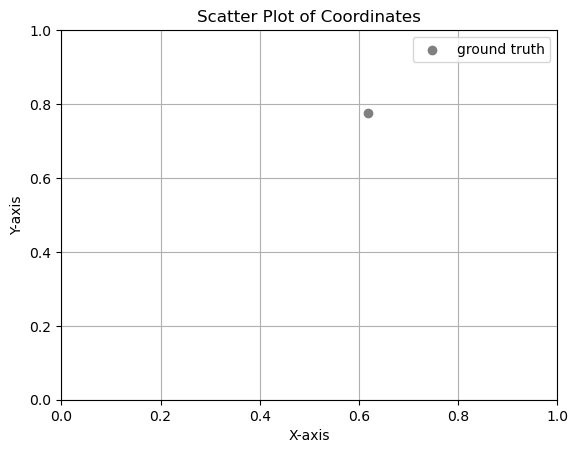

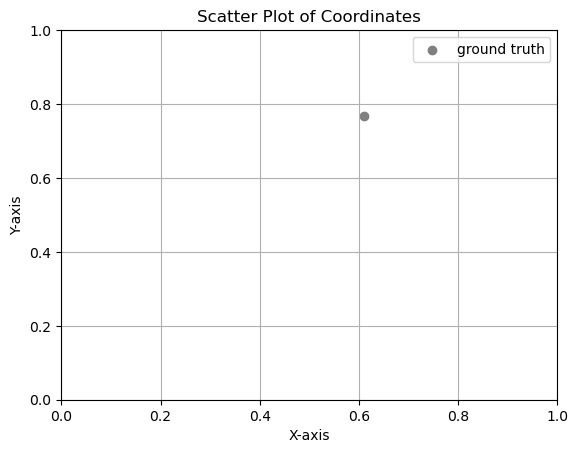

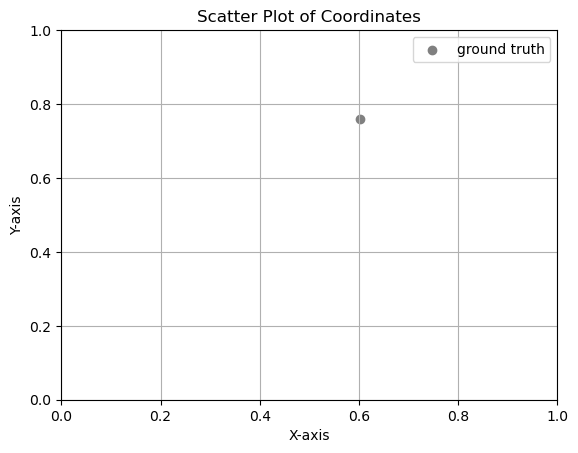

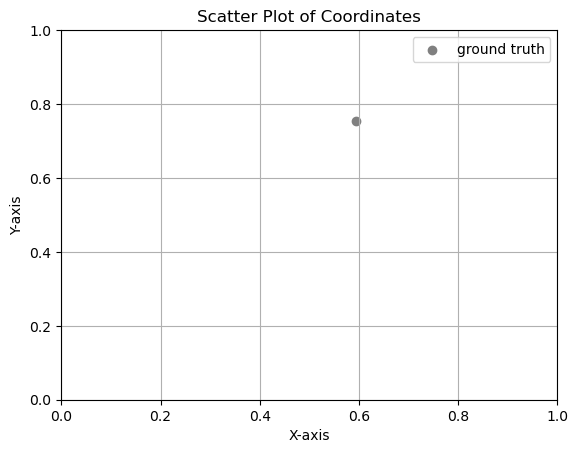

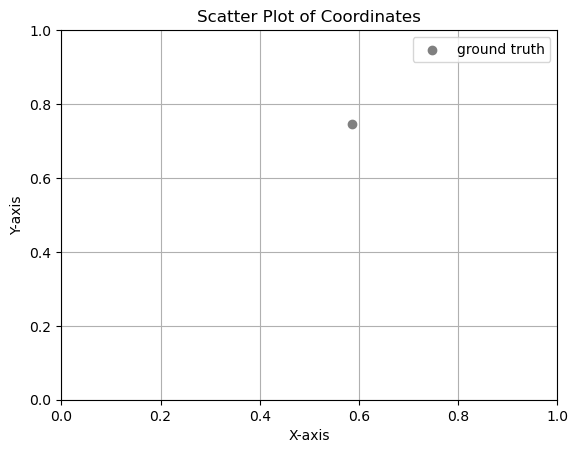

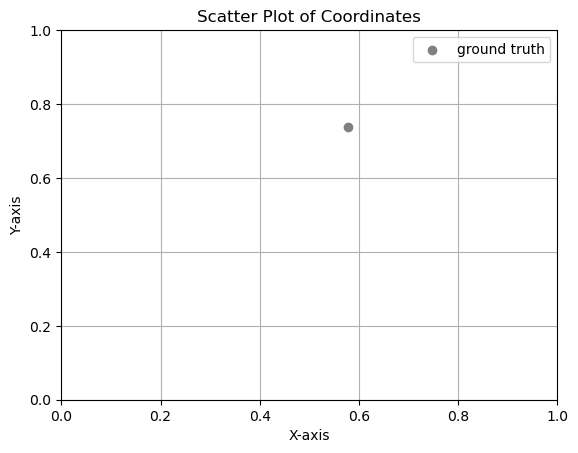

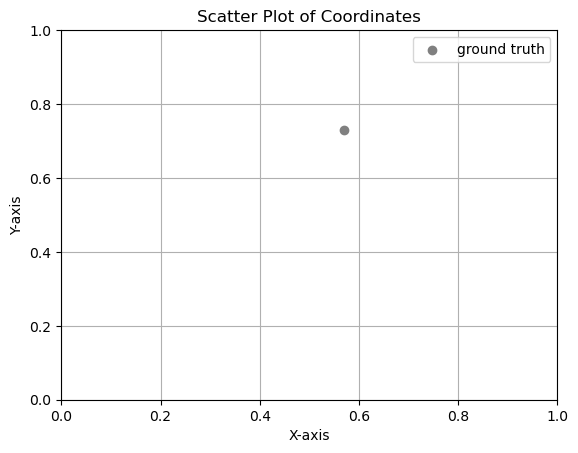

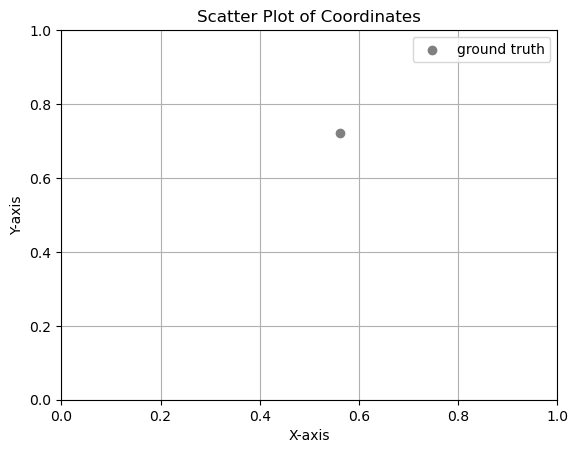

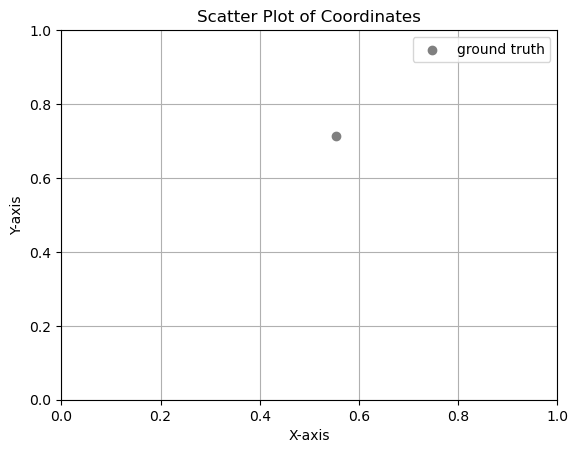

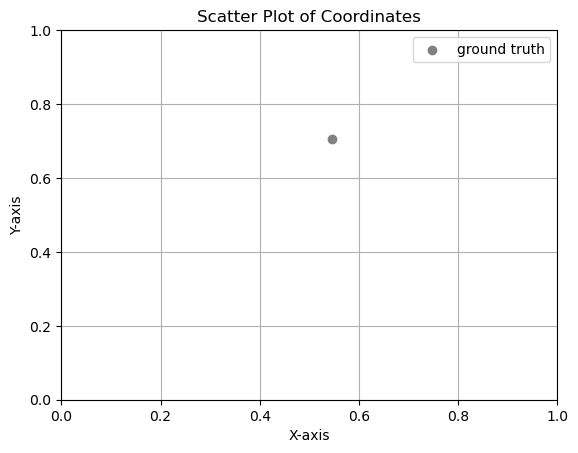

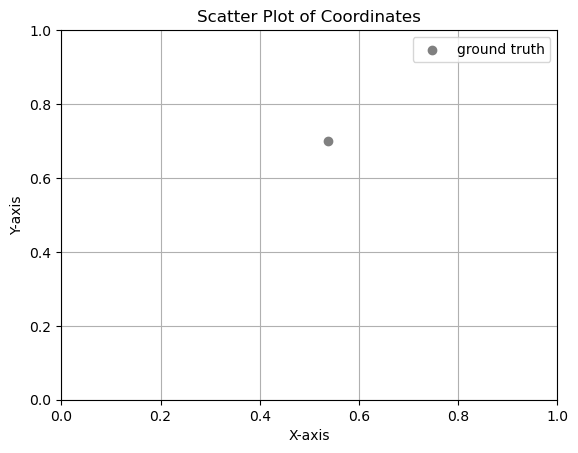

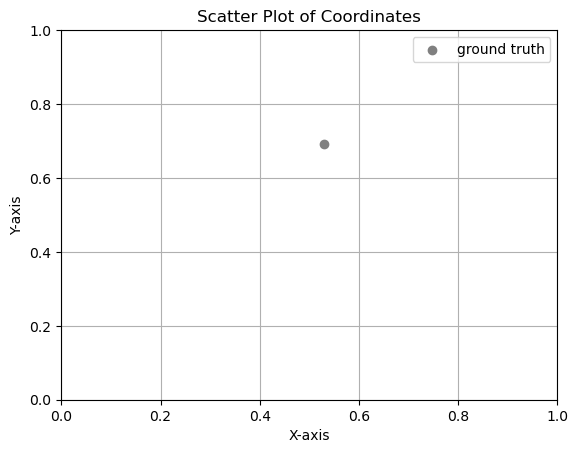

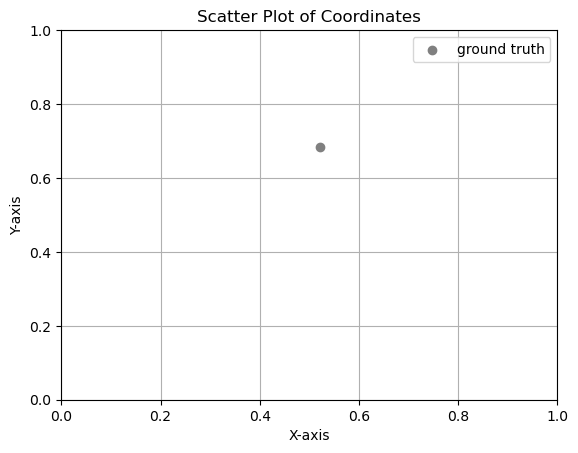

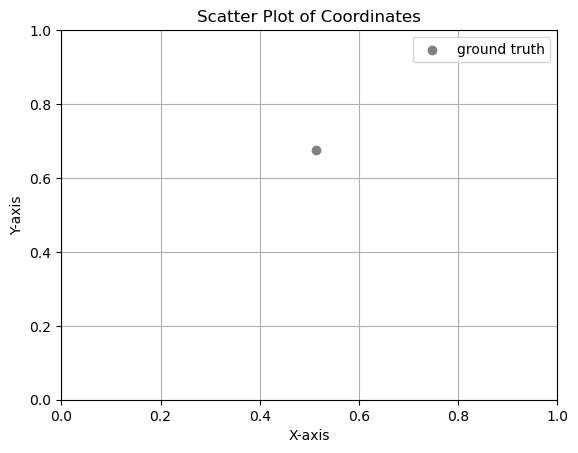

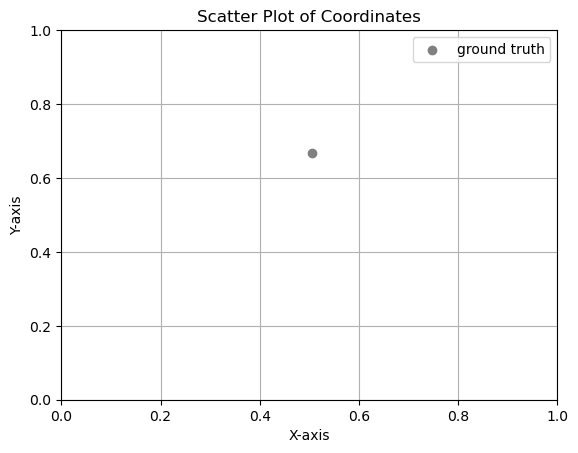

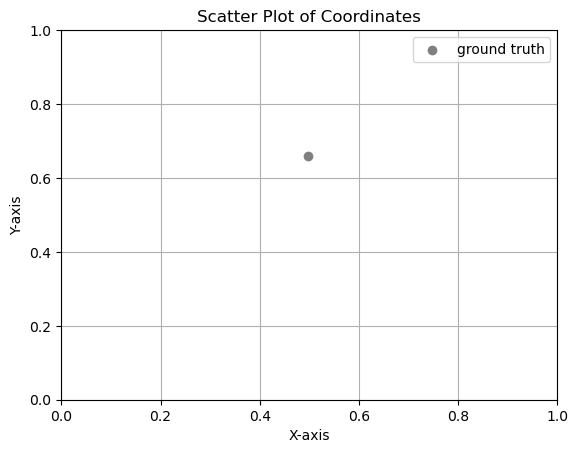

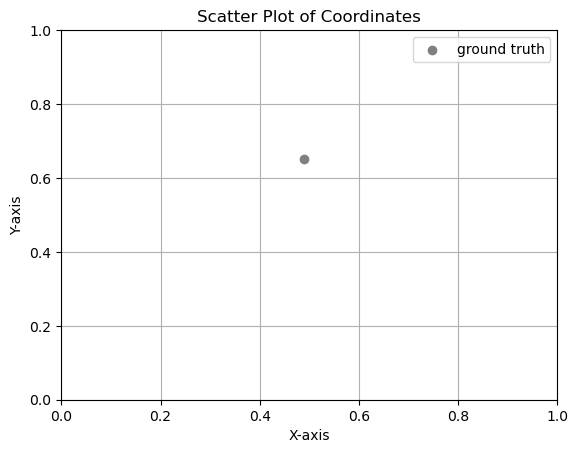

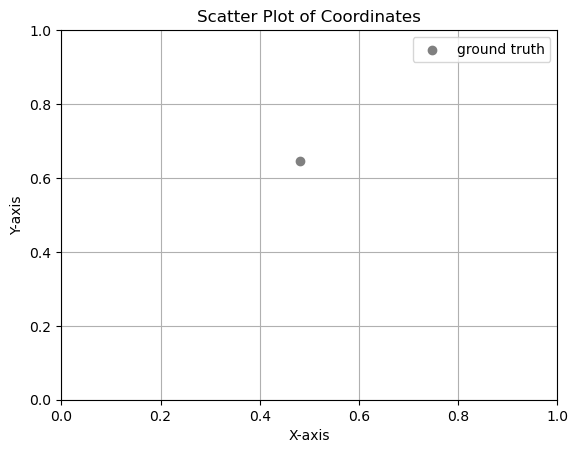

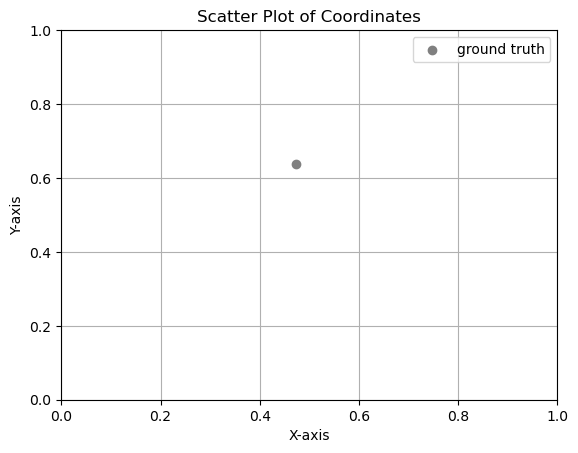

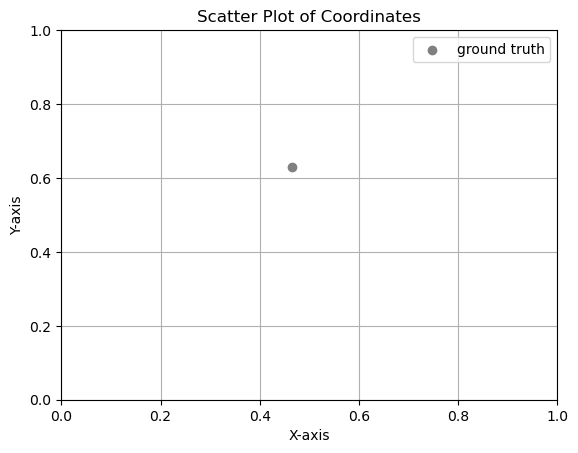

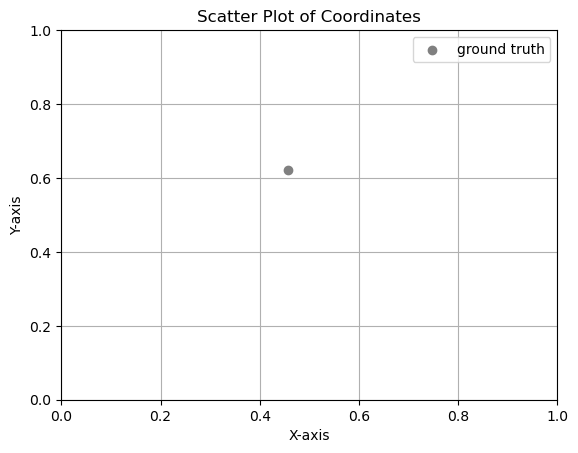

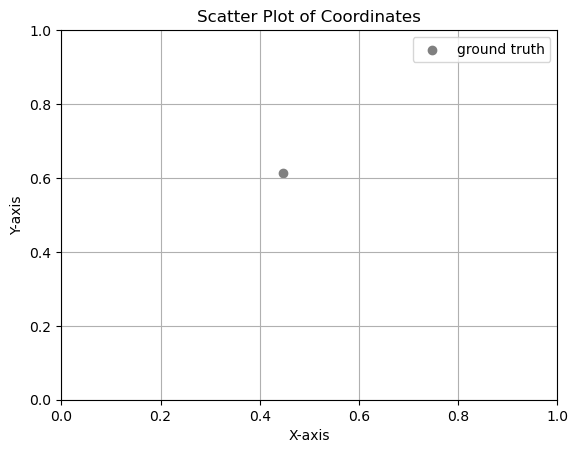

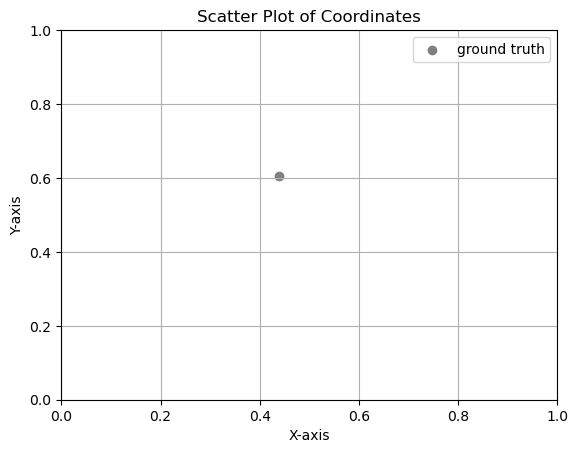

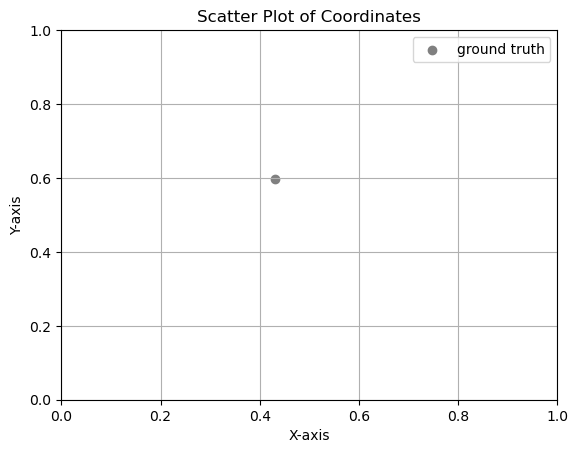

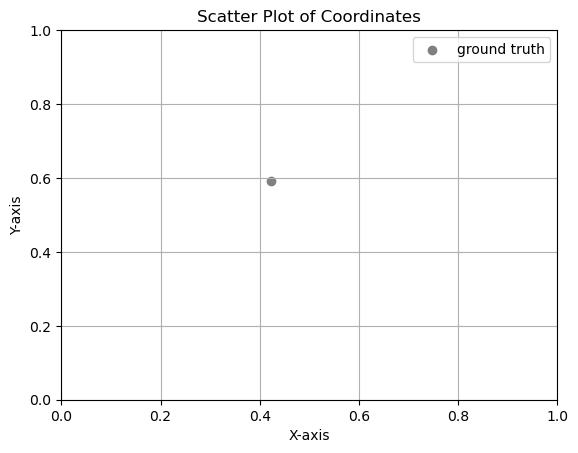

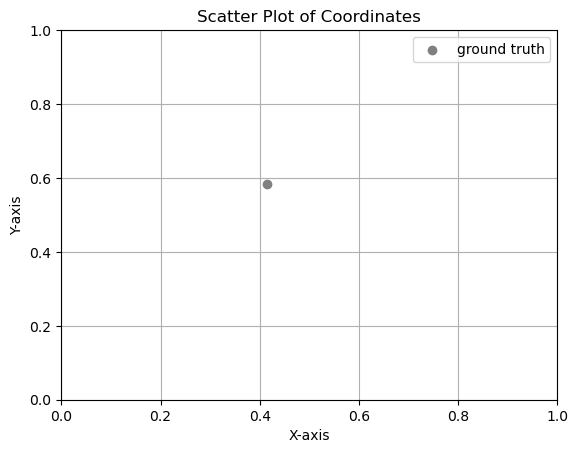

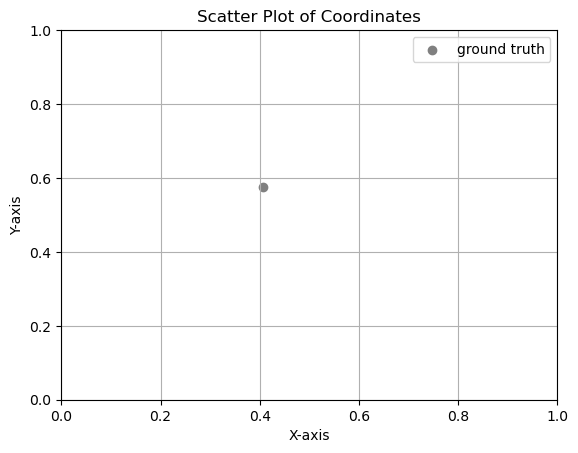

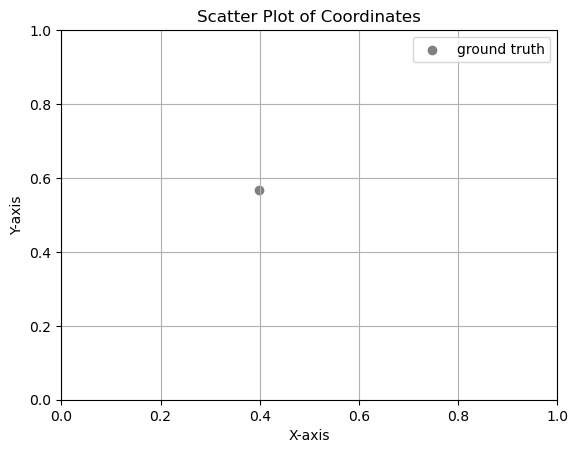

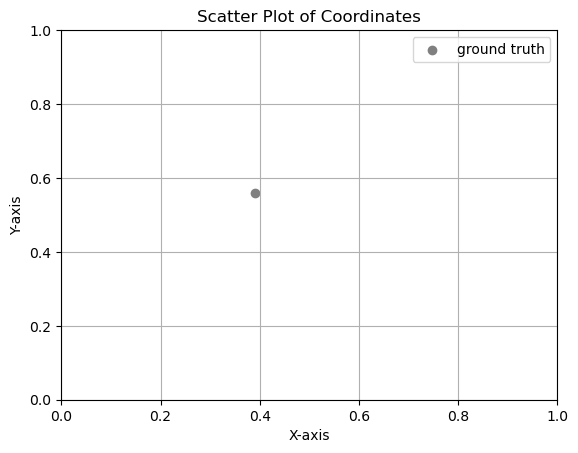

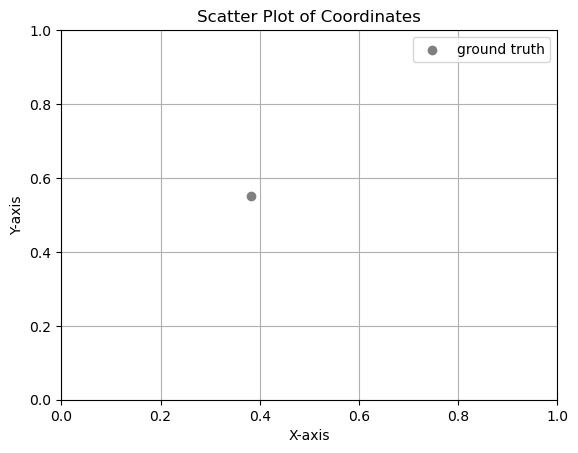

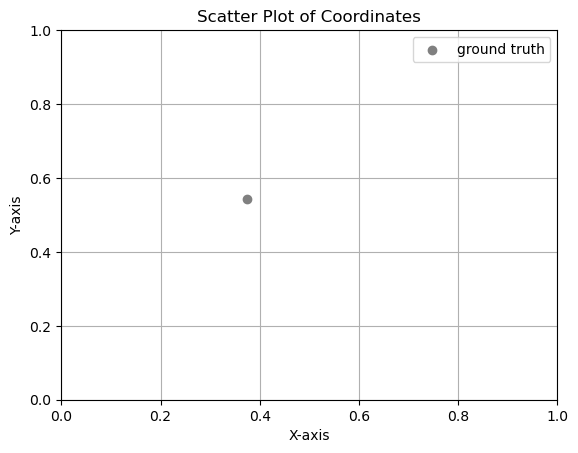

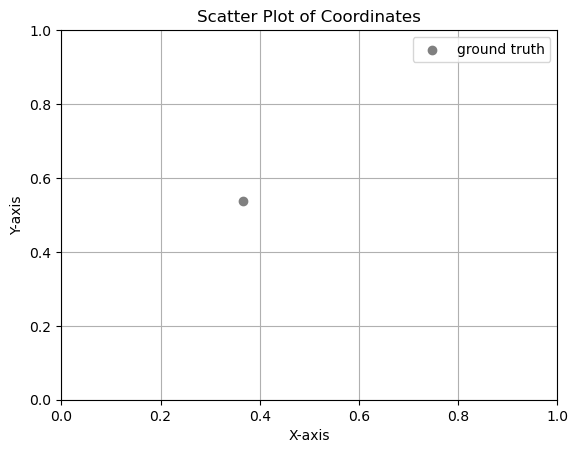

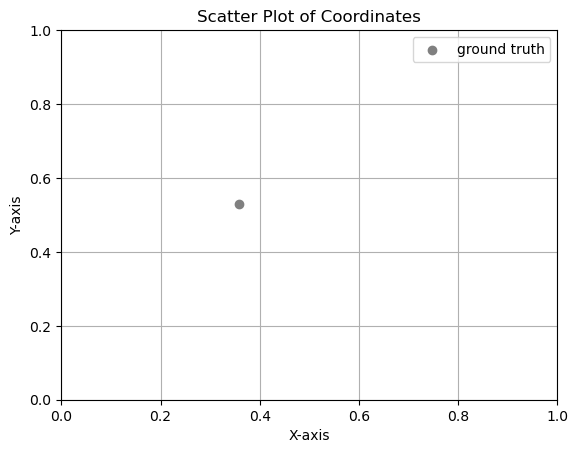

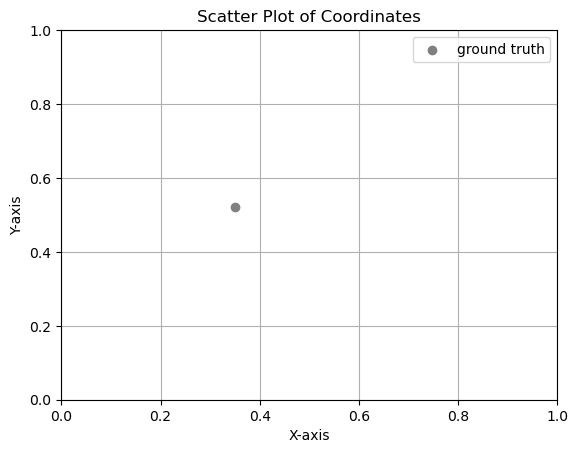

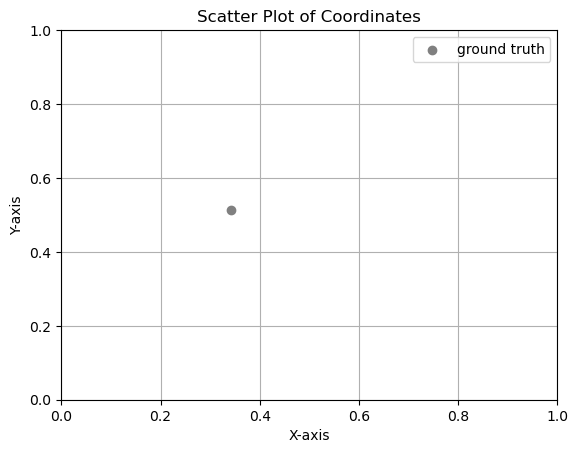

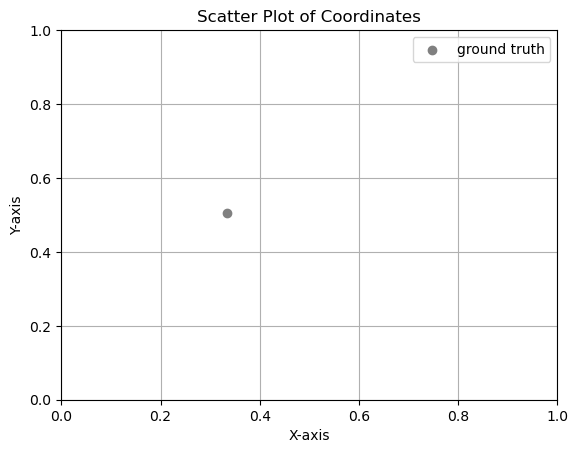

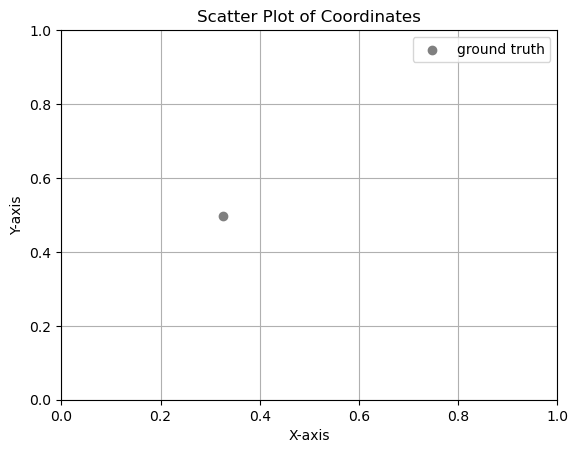

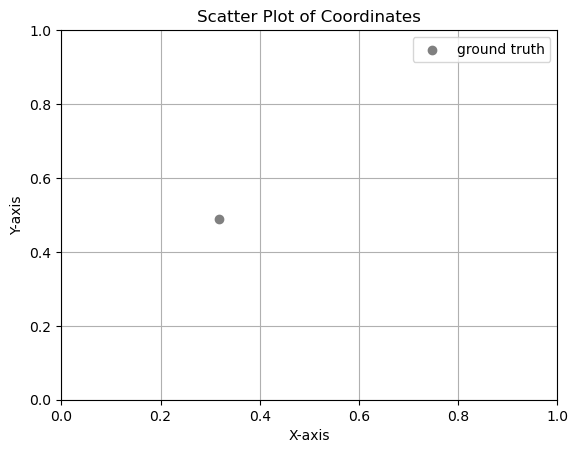

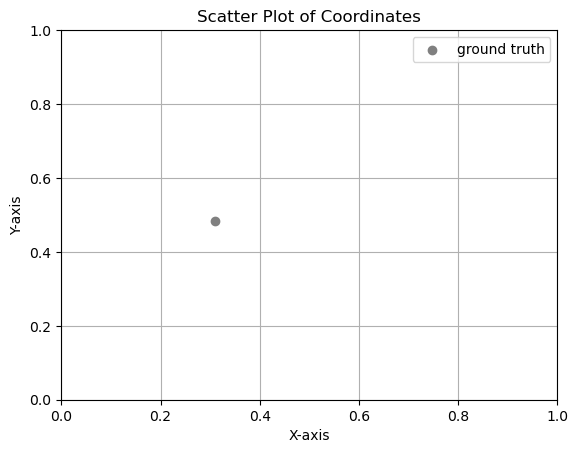

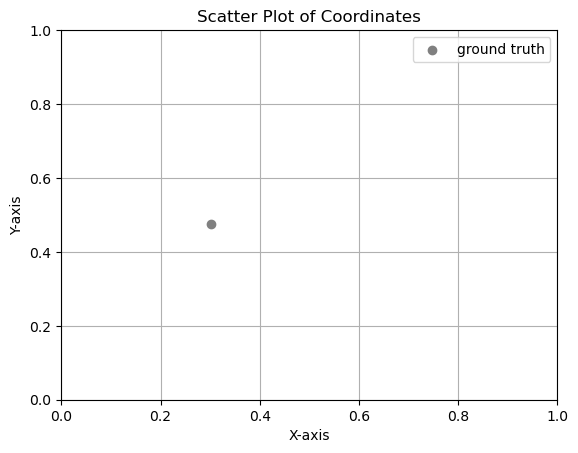

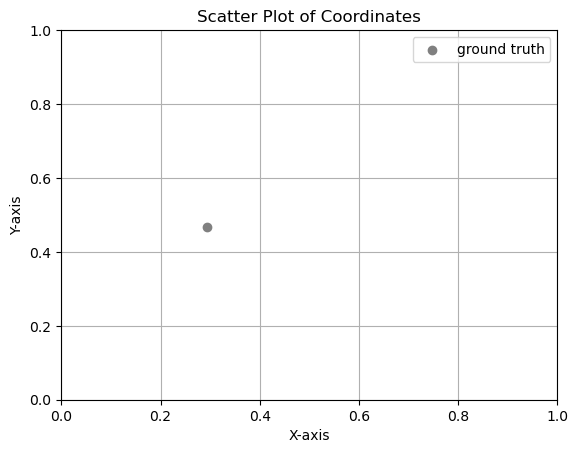

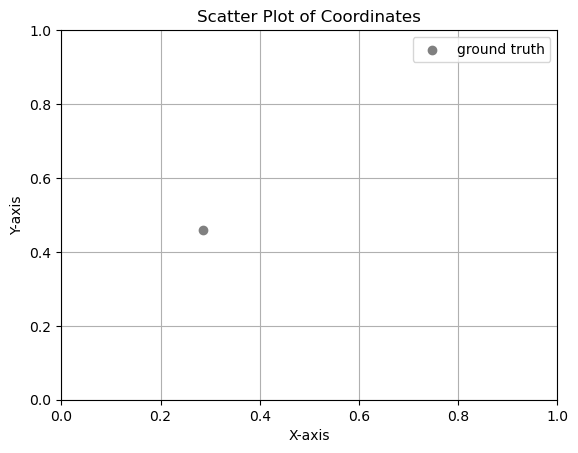

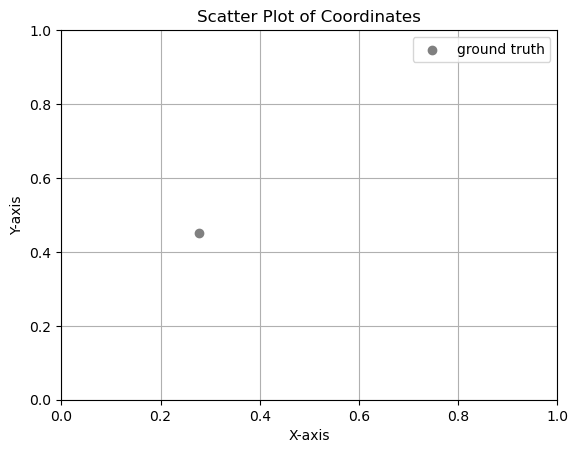

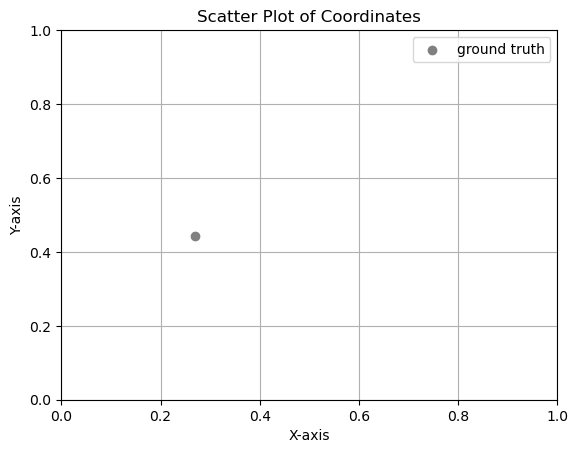

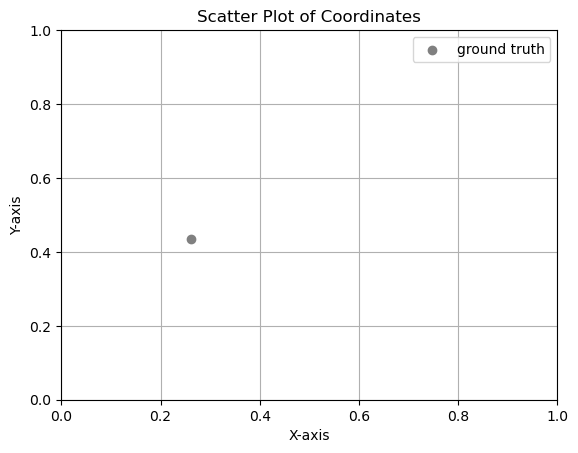

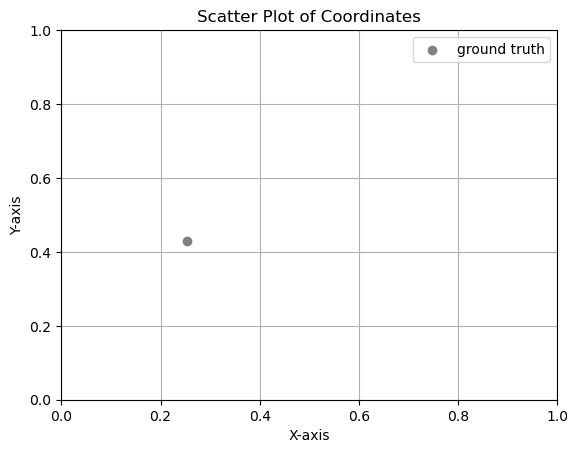

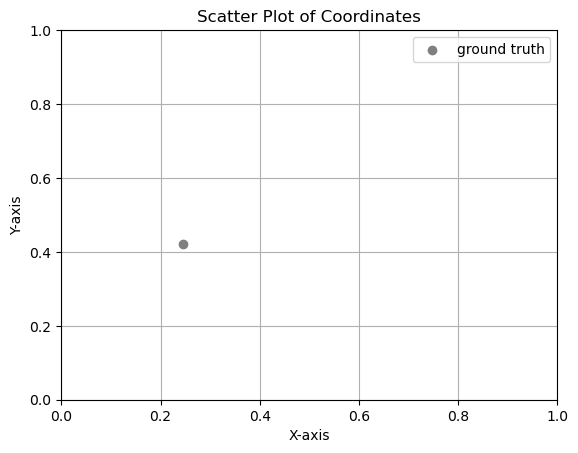

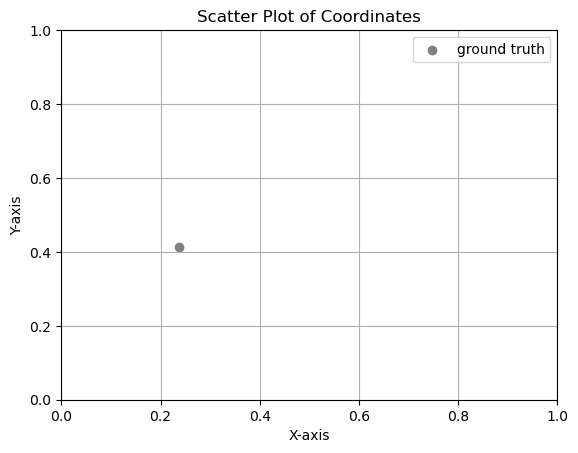

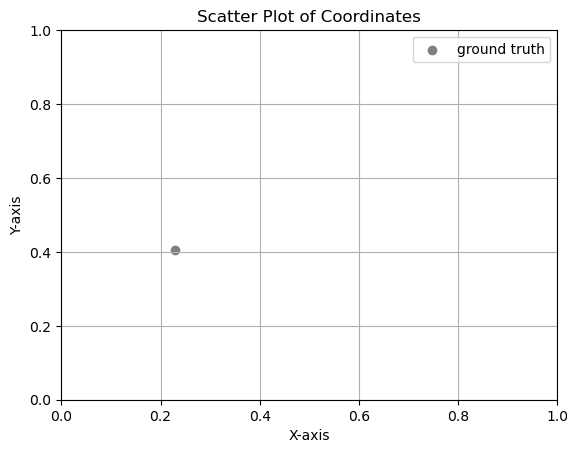

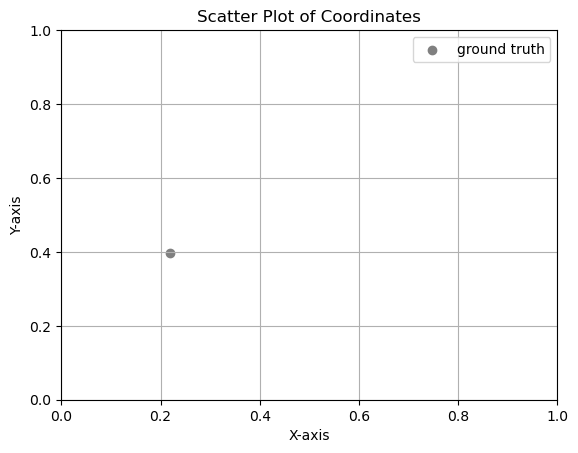

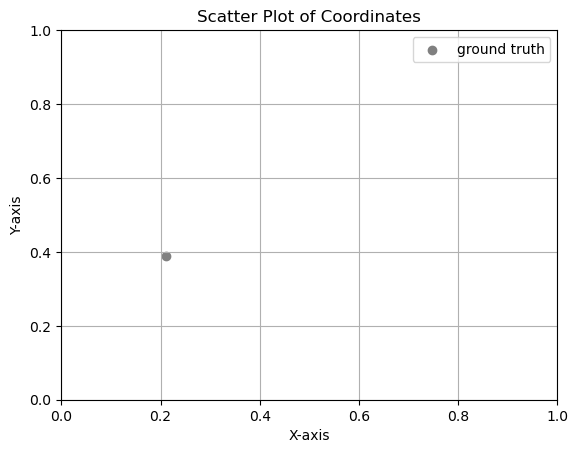

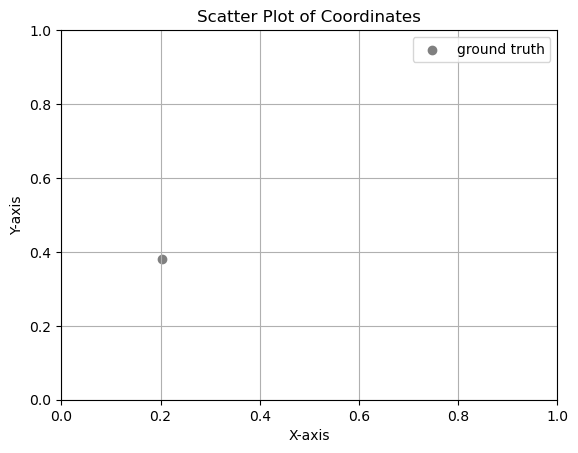

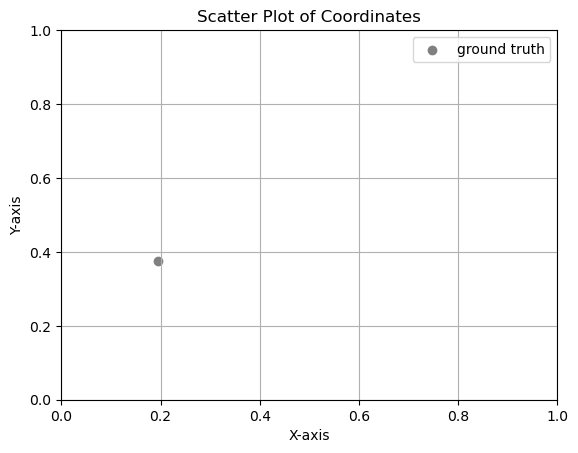

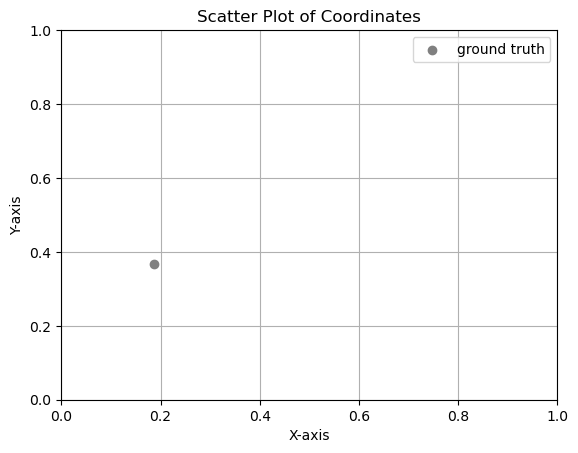

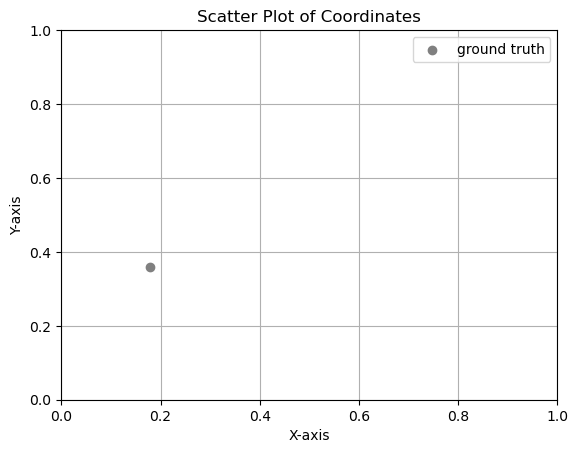

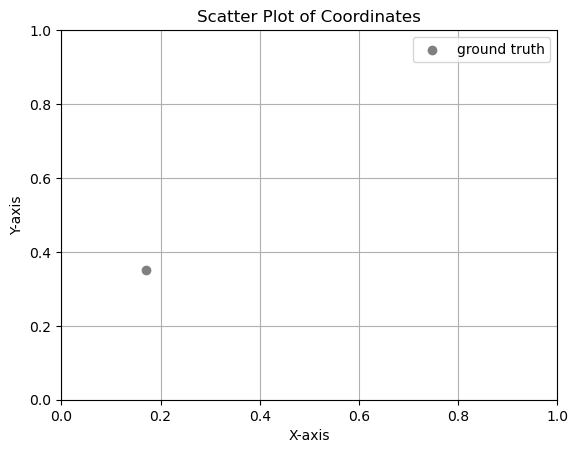

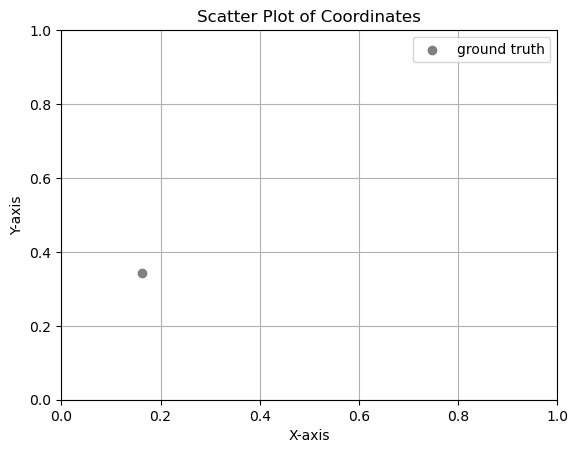

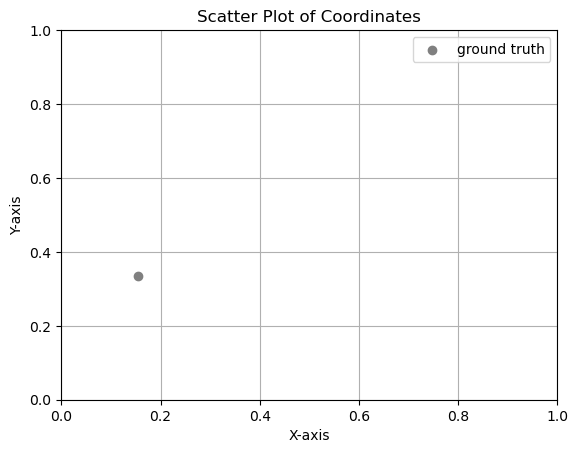

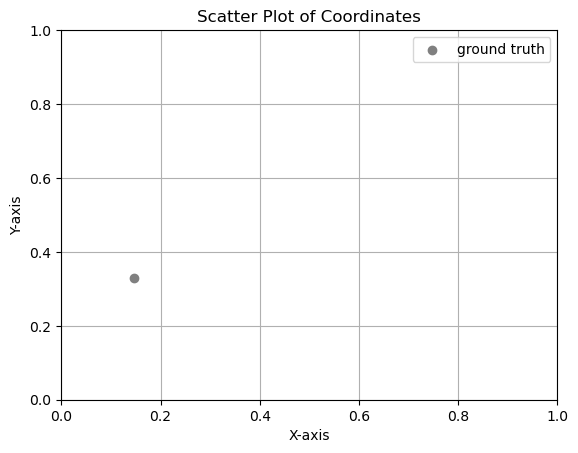

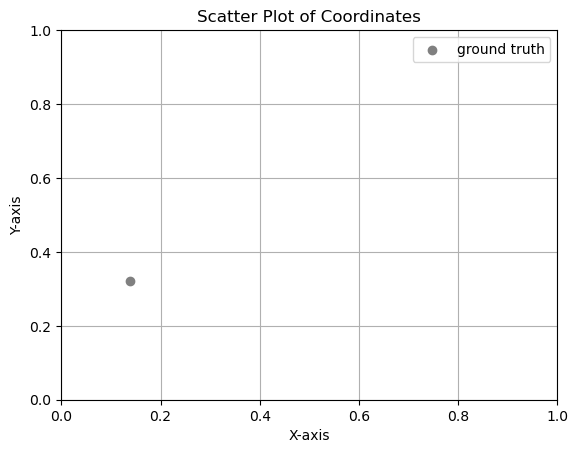

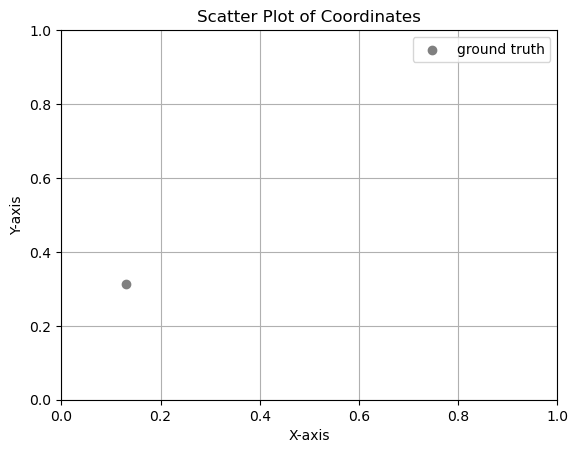

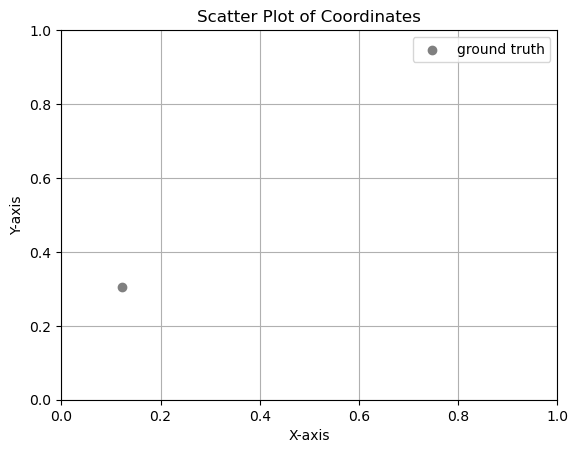

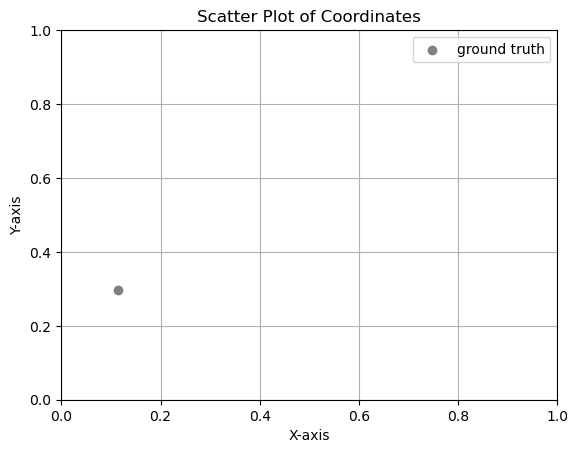

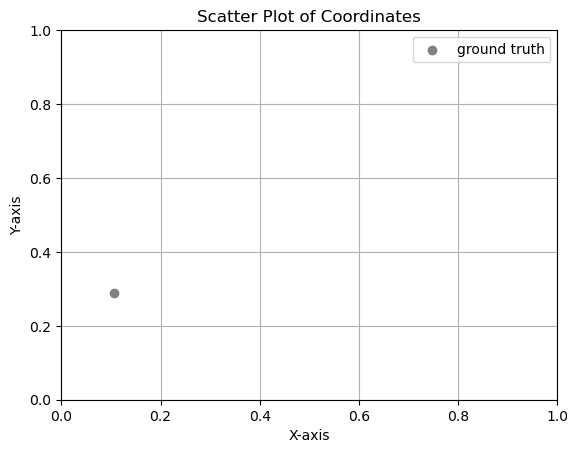

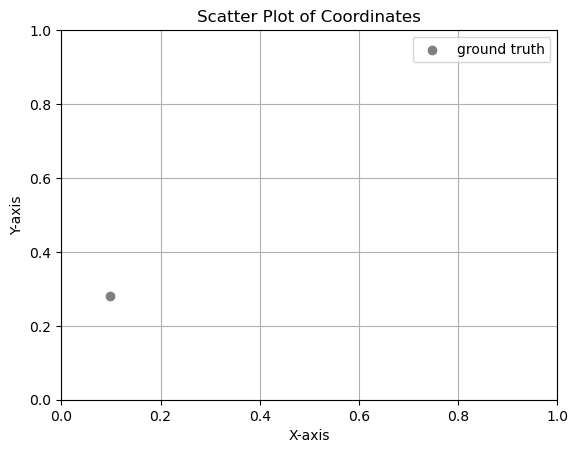

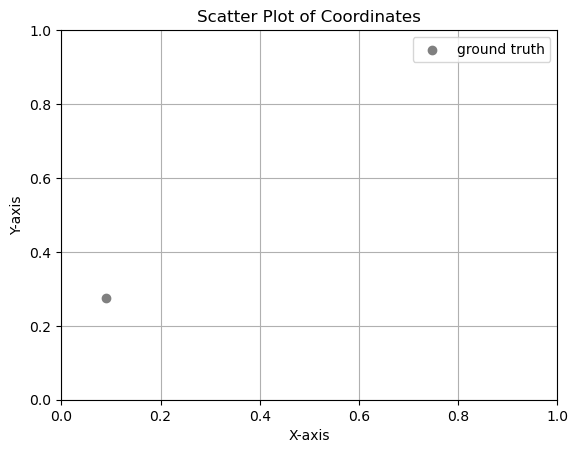

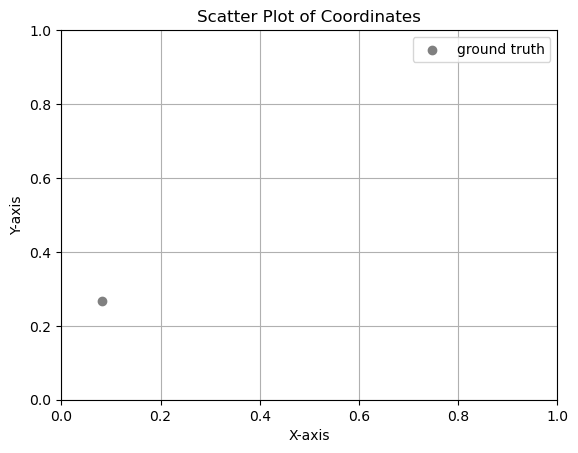

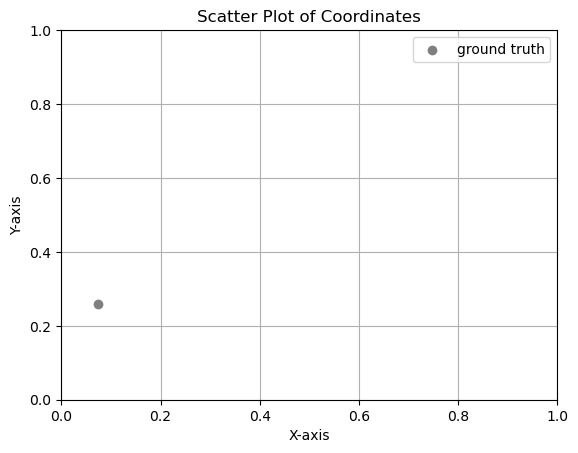

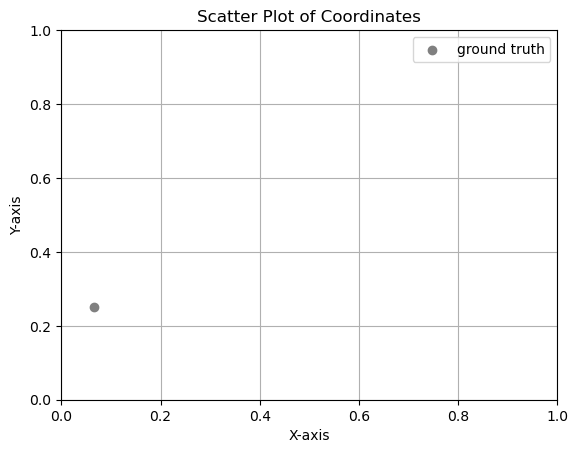

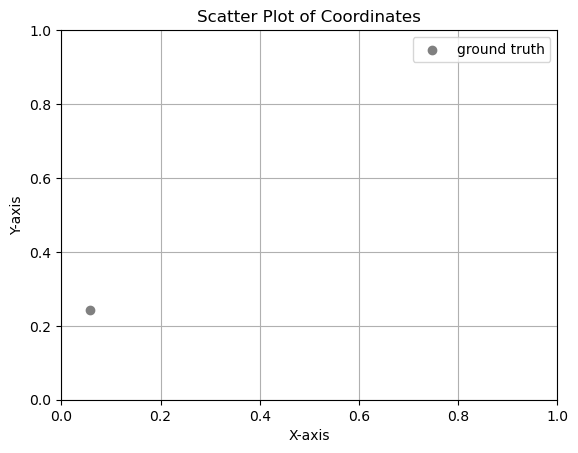

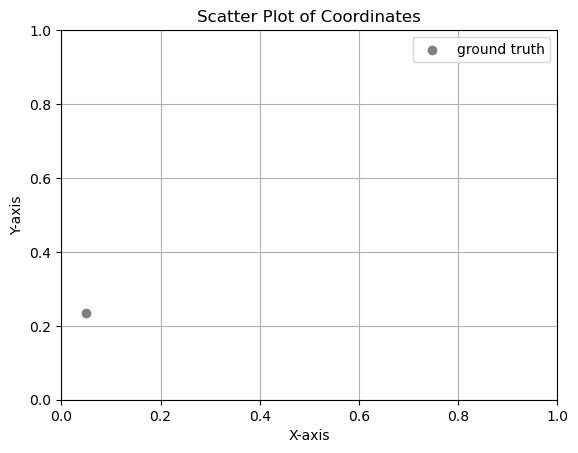

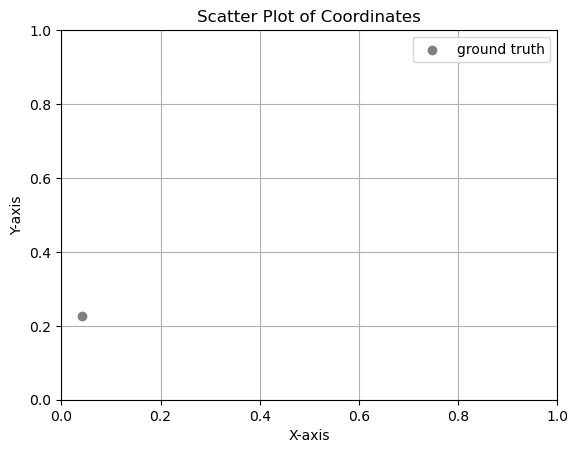

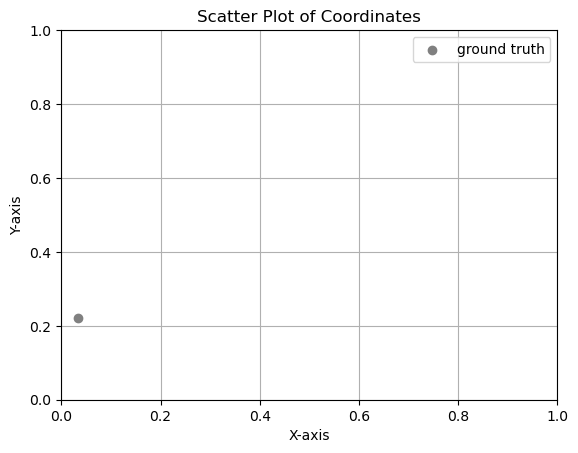

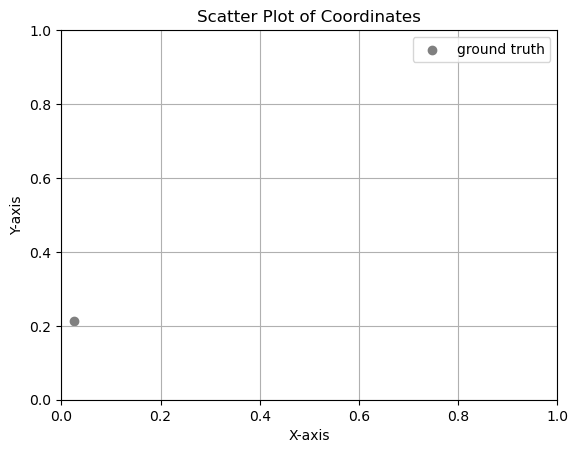

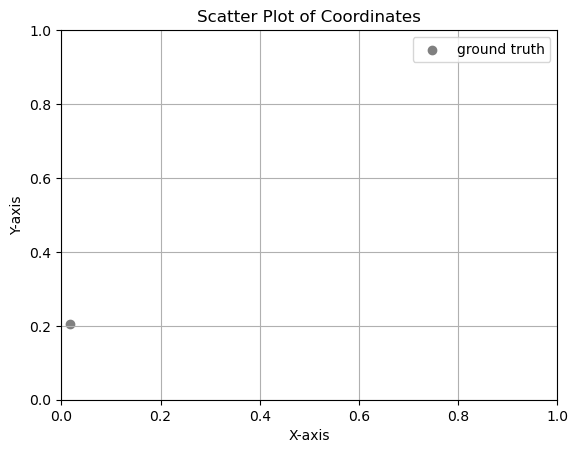

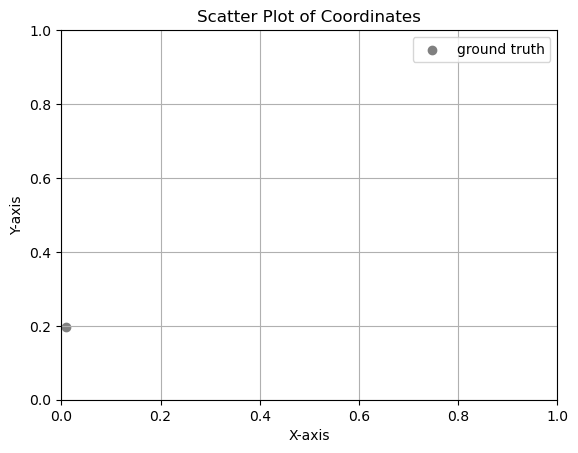

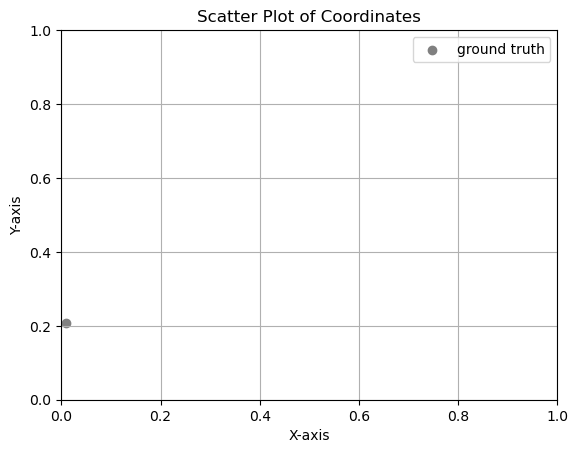

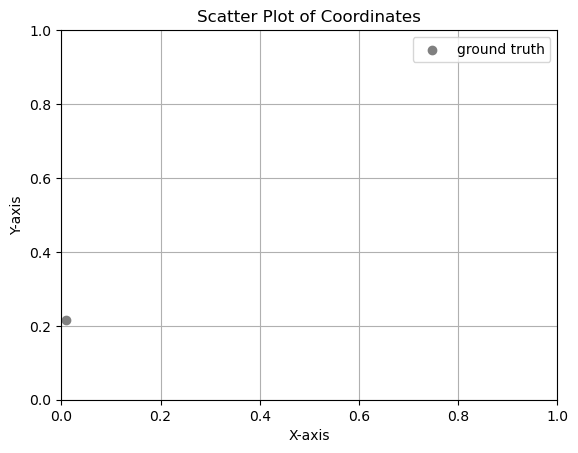

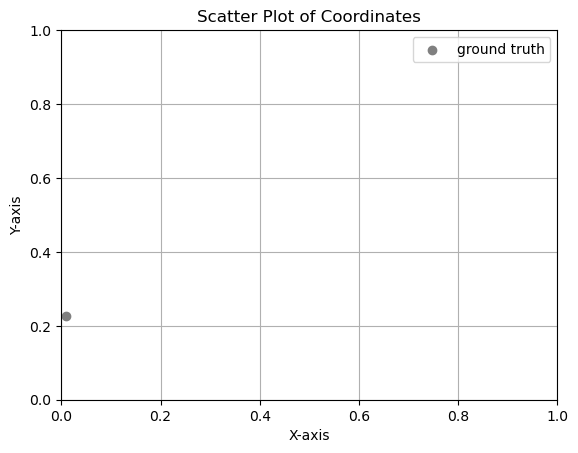

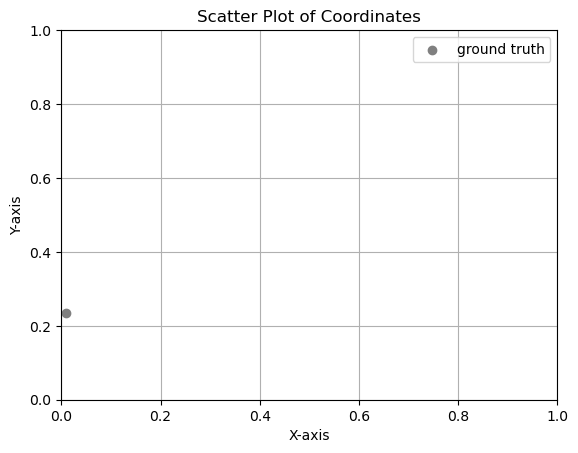

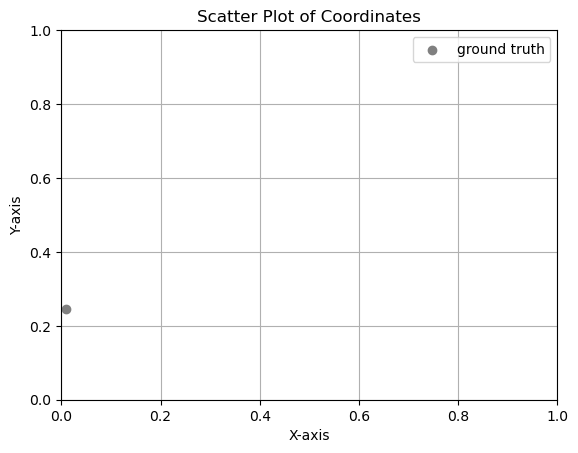

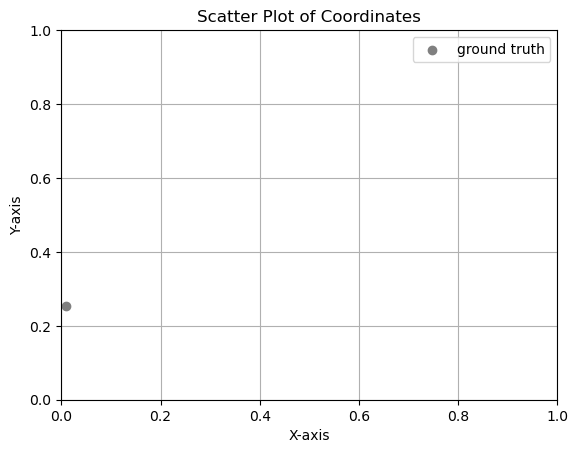

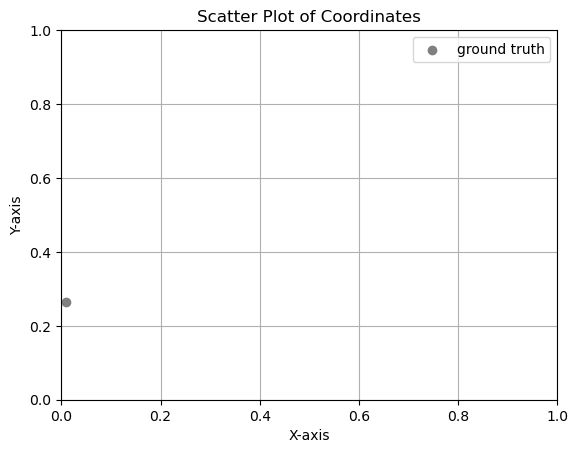

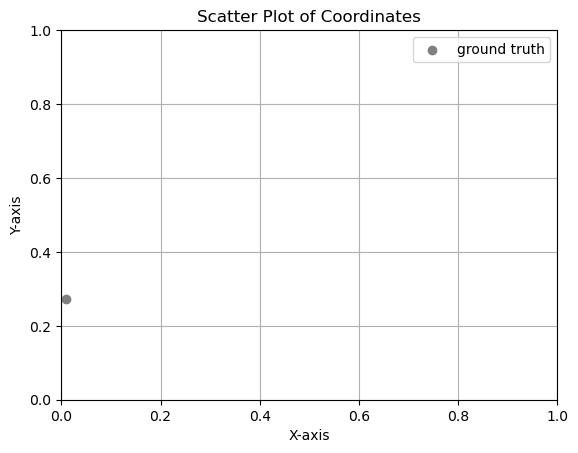

Epochs:   0%|                                                                | 0/50 [00:11<?, ?it/s]

written


Exception: 

<Figure size 640x480 with 0 Axes>

In [1]:
import argparse
import glob
import os
from collections import namedtuple
# from new_model import Classifier2D
from classifier import Classifier2D
from dataset import CustomDataset
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from earlystopping import EarlyStopping
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
import time
import cv2
%matplotlib notebook
model_path = "./model/model.pth"
TITLE = "BrandSilence"
SIZE_X = 640
SIZE_Y = 480
batch_size = 16
epochs = 50
num_bins = 150


def save_images_as_movie(filename, images, fps, ffmpeg_args='-y', ffmpeg_executable='ffmpeg'):
    """画像列を動画ファイルとして保存する.

    Parameters
    ----------
    filename: str
      保存先ファイル名.
    images: iterable of array-like
      動画として保存する画像列.
    fps: int
      動画のフレームレート.
    ffmpeg_args: str or iterable of str
      ffmpegの出力ファイル設定.
      例: PowerPointで再生可能かつ無圧縮にしたいなら '-vcodec rawvideo -pix_fmt yuv420p'
    ffmpeg_executable: str
      ffmpegの実行ファイルパス.

    Return
    ------
    completed_process: subprocess.CompletedProcess
      ffmpegの実行結果.

    Examples
    --------
    >>> import numpy as np
    >>> images = [np.full(shape=(128, 128), fill_value=v, dtype=np.uint8) for v in np.linspace(0, 255, 60)]
    >>> result = save_images_as_movie('example.mp4', images, fps=60)
    >>> result.check_returncode()
    """
    from subprocess import Popen, PIPE, CompletedProcess
    from cv2 import imencode

    if isinstance(ffmpeg_args, str):
        ffmpeg_args = ffmpeg_args.split()
    ffmpeg = Popen(
        args=[
            ffmpeg_executable,
            '-r', str(fps), '-f', 'image2pipe', '-i', '-',
            '-r', str(fps), *ffmpeg_args, filename,
        ],
        stdin=PIPE,
        stdout=PIPE,
        stderr=PIPE,
    )
    try:
        for image in images:
            success, buffer = imencode('.bmp', image)
            if not success:
                raise ValueError('imencode failed')
            ffmpeg.stdin.write(buffer)
    finally:
        out, err = ffmpeg.communicate()
    return CompletedProcess(
        args=ffmpeg.args, 
        returncode=ffmpeg.returncode, 
        stdout=out, 
        stderr=err,
    )



def plot_coordinates(pred, gt):
    """
    x, y座標の集合である(150, 2)の配列をプロットする関数

    Parameters:
    coordinates (numpy.ndarray): x, y座標の集合である配列
    """
    print(gt.shape)
    # 座標の取得
    x1 = pred[:, 0]
    y1 = pred[:, 1]
    x2 = gt[:, 0]
    y2 = gt[:, 1]

    # 散布図のプロット
    plt.scatter(x1, y1, label='prediction', color='red')
    plt.scatter(x2, y2, label='ground truth', color='gray')

    # グラフの設定
    plt.title('Scatter Plot of Coordinates')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)

    # グラフの表示
    plt.show()


def train():
    wandb.init(project="event_based_gaze_tracking", name=args.wandb)
    
    device = args.device
    classifier = Classifier2D(dropout=True, prob=0.2)
    classifier = classifier.to(torch.device(device))
    wandb.watch(classifier, log="all")
    

    # Load and split the dataset
    input_path = '../Dataset/input_data/'
    target_path = '../Dataset/target_data/'
    print("Start loading dataset")
    dataset = CustomDataset(input_path, target_path, TITLE, num_bins)

    total_size = 100
    train_size = int(0.7 * total_size)
    val_size = int(0.175 * total_size)
    test_size = total_size - train_size - val_size

    # Split the dataset
    train_dataset = Subset(dataset, range(0, train_size))
    val_dataset = Subset(dataset, range(train_size, train_size + val_size))
    test_dataset = Subset(dataset, range(train_size + val_size, total_size))

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    early_stopping = EarlyStopping(patience=12, verbose=True, path=args.model_path)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate)
    train_loss_epoch = []
    val_loss_epoch = []  # List to store validation losses

    for epoch in tqdm(range(args.total_epochs), desc="Epochs", ncols=100, position=0):
        classifier.train()
        avg_train_loss = 0.
        for i, (frames, labels) in enumerate(tqdm(train_loader, desc=f"Epoch{epoch+1} Batches", ncols=100, position=1, leave=False)):
            assert frames.size(1) == labels.size(1) == num_bins, f"data length is not what you expected: {frames.shape}, {labels.shape}"
            # check if the data is valid

            for j in range(num_bins):
                frame = frames[:, j:j+1].to(device)
                label = labels[:, j:j+1].to(device)
                optimizer.zero_grad()
                outputs = classifier(frame)
                loss = criterion(outputs, label)
                loss.backward()

                # ここで計算グラフを可視化
                if epoch == 0 and i == 0 and j == 0:  # 最初のバッチのみで計算グラフを描画
                    make_dot(loss, params=dict(classifier.named_parameters())).render("./Dataset/calc_log", format="png")

                optimizer.step()
                avg_train_loss += loss.item() * len(frame)  # Multiply by batch size

        avg_train_loss /= train_size
        train_loss_epoch.append(avg_train_loss)
        early_stopping(avg_train_loss, classifier)

        avg_val_loss = 0.
        classifier.eval()
        with torch.no_grad():
            for i, (frames, labels) in enumerate(tqdm(val_loader, desc=f"Validation{epoch+1} Batches", ncols=100, position=2, leave=False)):
                assert frames.size(1) == labels.size(1) == num_bins, f"data length is not what you expected: {frames.shape}, {labels.shape}"
                for j in range(num_bins):
                    frame = frames[:, j:j+1].to(device)
                    label = labels[:, j:j+1].to(device)
                    outputs = classifier(frame)
                    val_loss = criterion(outputs, label)
                    avg_val_loss += val_loss.item() * len(frame)  # Multiply by batch size

        avg_val_loss /= val_size
        val_loss_epoch.append(avg_val_loss)
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss})

        if early_stopping.early_stop:
            print("Early stopping")
            break

        # if epoch !=0 and epoch % 25 == 0:
        #     torch.save(classifier.state_dict(), os.path.join(args.model_save_dir, f'{args.model_name}_%d.pth' % epoch))
        #     wandb.save(os.path.join(args.model_save_dir, f'{args.model_name}_%d.pth' % epoch))

    classifier.load_state_dict(torch.load(args.model_path))
    avg_test_loss = 0.
    classifier.eval()


    with torch.no_grad():
        start_time = time.time()  # Start the timer for the entire loop
        loop_count = 0  # Initialize loop counter
        pred_plot = []

        for (frames, labels) in tqdm(test_loader, desc="Testing Batches", ncols=100, position=2, leave=False):
            loop_count += 1  # Increment the loop counter
            for j in range(num_bins):
                frame = frames[:, j:j+1].to(device)
                label = labels[:, j:j+1].to(device)
                outputs = classifier(frame)
                test_loss = criterion(outputs, label)
                avg_test_loss += test_loss.item() * len(frame)
                pred_plot.append(outputs.to('cpu').detach().numpy())

        if loop_count == 1:
                pred_plot = np.array(pred_plot)
                for j in range(batch_size//2):
                    print(pred_plot[:, j])
                    print(labels[j])
                    assert labels[j].shape == (150, 2)
                    plot_coordinates(pred_plot[:, j], labels[j].to('cpu'))

        end_time = time.time()  # Stop the timer for the entire loop
    elapsed_time = end_time - start_time  # Calculate the elapsed time for the entire loop
    avg_time_per_loop = elapsed_time / test_size # Calculate the average time per loop
    print(f"Time taken for the entire loop: {elapsed_time:.4f} seconds")
    print(f"Average time taken for one loop iteration: {avg_time_per_loop:.4f} seconds")
    avg_test_loss /= test_size
    print(f"Test loss: {avg_test_loss}")
    wandb.finish()

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Arguments for using the eye visualizer')
    parser.add_argument('--subject', type=int, default=22, help='which subject to evaluate')
    parser.add_argument('--eye', default='left', choices=['left', 'right'],help='Which eye to visualize, left or right')
    parser.add_argument('--data_dir', default=os.path.join(os.getcwd(), 'eye_data'),help='absolute path to eye_data')
    parser.add_argument('--buffer', type=int, default=1000, help='How many events to store before displaying.')
    parser.add_argument('--model_path', type=str, default='./model/model.pth', help='Directory to save the model weights')
    parser.add_argument('--model_name', type=str, default='G030_c32', help='Base name for saving the model weights without extension')
    parser.add_argument("--device",type=str,help="device to run on, 'cpu' or 'cuda', only apply to pytorch, default: CPU",default="cuda")
    parser.add_argument('--total_epochs', type=int, default=1000, help='the Number of Epochs')
    parser.add_argument('--batch_size', type=int, default=16, help='the Number of Batches')
    parser.add_argument('--wandb', type=str,  help='the name of wandb project')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate')
    
    # args = parser.parse_args()
    args = parser.parse_args(args=["--learning_rate", "0.001", "--total_epochs", f"{epochs}", "--batch_size", f"{batch_size}", "--wandb", "new_model_project_from_eye_gazing"])


    train()